# DS в разведке и добыче нефти

**Описание:**\
..Им требовался готовый к испытаниям доброволец с пытливым умом для поиска древних артефактов: «Камень Судеб», «Око Дракона» и «Священная Амброзия».. Артефакты спрятаны где-то под землей.. 

**Цель:**\
Разработать модель ML, предсказывающую сроки поиска артефактов. Оптимизировать процесс поиска артефактов. При этом учитывая сложные геологические и технические условия подземных рудников.

**Задача:**
1. разработать модель машинного обучения, которая будет предсказывать срок получения артефактов;
2. определить и протестировать важные признаки, которые можно использовать для обучения модели;
3. провести детальный анализ (EDA), чтобы определить, какие признаки лучше всего предсказывают целевую переменную;
  
Модель машинного обучения должна учитывать древние знания о поисках магических артефактов в разных королевствах, на различных землях, полученные из карты краснолюдов.

**Описание данных:**\
Древняя карта, созданная краснолюдами, магические символы на которой указывают на места старых расщелин и подземных туннелей, где могут быть спрятаны артефакты. Возможны технические сложности.
- *Целевая переменная* - Срок поиска артефакта;

**Метрики ожидаемого результата:**\
Выбери метрику оценки качества модели, которая больше подходит для решения задачи регрессии. Выбор алгоритма ML на твое усмотрение. Результатом является достижение как можно меньшей предсказательной ошибки модели.

**Требования к формату решения:**
1. Jupyter Notebook: Полный код и результаты, позволяющие воспроизвести решение.
2. Обоснованное описание всех этапов решения задачи: как были обработаны данные, какие модели использовались, какие допущения были приняты.

**План работы**
1. Загрузка данных;
2. Ознакомление;
3. EDA;
4. Предобработка;
5. Исследование;
6. Анализ признаков;
7. Вывод

 ## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     GridSearchCV)
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb

from tqdm import tqdm
import re
from IPython.display import display
tqdm.pandas()

In [2]:
try:
    data = pd.read_csv('data/data.csv')
except Exception as err:
    print('Возникла ошибка:\n', err)

## Подготовка и анализ

In [3]:
data.shape

(13416, 53)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13416 entries, 0 to 13415
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Наименование королевства                    13416 non-null  object 
 1   Наименование земли                          13416 non-null  object 
 2   Наименование хребта                         13416 non-null  object 
 3   Наименование расщелины                      13416 non-null  int64  
 4   Цель                                        13416 non-null  object 
 5   Тип расщелины                               13414 non-null  object 
 6   Категория расщелины                         13416 non-null  object 
 7   Назначение расщелины                        10800 non-null  object 
 8   Участки                                     13416 non-null  object 
 9   Тип отвилка                                 13416 non-null  object 
 10  Технологич

**Заключение:**
- полное к-во значений в стоблце 13416;
- часть столбцов не имеет полного набора;
    - 27 и 28 признаки имеют очень мало значений;
- данные имеют разный тип;
- признаков много, их можно разбить на несколько похожих таблиц:
    - по типу;
    - наименованию(смыслу);
- целевой признак(Срок поиска артефакта) не определён. Вероятно стоит выбрать признаки связанные с временем поиска и их обобщить;
- имена признаков представлены в не магическом письме, согласно кодексу чародеев, стоит их превести из людского в змеиный;

### Перевод признаков на змеиный

Сохраним старые наименования и проведём преобразование

In [5]:
data_columns_raw = data.columns

In [6]:
data.columns = [el.lower().replace(' ', '_') for el in data.columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13416 entries, 0 to 13415
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   наименование_королевства                    13416 non-null  object 
 1   наименование_земли                          13416 non-null  object 
 2   наименование_хребта                         13416 non-null  object 
 3   наименование_расщелины                      13416 non-null  int64  
 4   цель                                        13416 non-null  object 
 5   тип_расщелины                               13414 non-null  object 
 6   категория_расщелины                         13416 non-null  object 
 7   назначение_расщелины                        10800 non-null  object 
 8   участки                                     13416 non-null  object 
 9   тип_отвилка                                 13416 non-null  object 
 10  технологич

Имена столбцов представлены в змеином регистре

### Разбиение данных на группы

Для упрощения предобработки и струтурирования разобъём признаки на те которые можно отнести к наименованиям, те, которые имеют отношения к значениям показателей и те, которые могут иметь отношение ко времени поиска артефакта.

In [7]:
data_names = data.loc[:, 'наименование_королевства': 'тип_инструмента']

In [8]:
data_values = pd.concat([data.loc[:, 'количество_труб': 'путь_поиска_в_первом_отвилке'],
                          data.loc[:, 'количество_аварий': 'общий_путь_поиска']], axis=1)

In [9]:
data_times = pd.concat([data.loc[:, 'общее_время_поиска': 'общее_время_простоев'],
                       data.loc[:, ['дата_начала_поиска', 'дата_окончания_поиска']]], axis=1)

**Заключение:**\
Теперь можно проанализировать и обработать группы данных отдельно.

### data_names

Эта часть будет посвящана общему осмотру. Будем изучаться распределение, уникальность, где-то выбросы(в основном в категориальных столбцах нет смысла это делать. Выбросом будет являться наиболее популярный столбец).

In [10]:
data_names.columns

Index(['наименование_королевства', 'наименование_земли', 'наименование_хребта',
       'наименование_расщелины', 'цель', 'тип_расщелины',
       'категория_расщелины', 'назначение_расщелины', 'участки', 'тип_отвилка',
       'технологическая_особенность', 'статус_поиска',
       'помощник_по_контролю_поиска', 'помощник_по_поиску',
       'помощник_по_наклонным_расщелинам', 'помощник_по_зельям',
       'помощник_по_долбилам', 'помощник_по_исследованиям',
       'помощник_по_укреплению', 'помощник_по_огненным_заклятиям',
       'помощник_по_подвескам', 'помощник_по_вырезке_окна', 'тип_инструмента'],
      dtype='object')

In [11]:
data_names.loc[:, 'наименование_королевства': 'статус_поиска'].head()

,наименование_королевства,наименование_земли,наименование_хребта,наименование_расщелины,цель,тип_расщелины,категория_расщелины,назначение_расщелины,участки,тип_отвилка,технологическая_особенность,статус_поиска
0,Кэдвен,Приобия,684,2903,поиск,наклонная,Нагнетательная,Магическое воздействие,верхнее укрепление+среднее укрепление+основное...,Материнский,наклонная,завершен
1,Темерия,Сутор,1141,1332,поиск,горизонтальная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,горизонтальная + отвилков 40,завершен
2,Кэдвен,Приобия,18А.28,1027,поиск,наклонная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,наклонная,завершен
3,Кэдвен,Приобия,9А.18,4208,поиск,наклонная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,наклонная,завершен
4,Кэдвен,Приобия,627,9352,поиск,наклонная,Нагнетательная,Магическое воздействие,верхнее укрепление+среднее укрепление+основное...,Материнский,наклонная,завершен


In [12]:
data_names.loc[:, 'помощник_по_контролю_поиска': 'тип_инструмента'].head()

,помощник_по_контролю_поиска,помощник_по_поиску,помощник_по_наклонным_расщелинам,помощник_по_зельям,помощник_по_долбилам,помощник_по_исследованиям,помощник_по_укреплению,помощник_по_огненным_заклятиям,помощник_по_подвескам,помощник_по_вырезке_окна,тип_инструмента
0,Геральт и Компания,Компания Глоруин,,Краснолюдский Цех Буровых Технологий,,Гильдия Временных Исследований,Искусство Стихийных Служб,,,,
1,,,Ковен Ветра и Бурения; Цех Технологического Ге...,Альянс Мудрецов и Травников Нильфгаарда,Гильдия Новых Технологий,Стихия,Магическая Торговая Управа,,,,
2,Нежить и Услуги,Компания Глоруин,Туманные Кузнецы Ши,Краснолюдский Цех Буровых Технологий,АО НПП Защитники Проклятых,,Строительный Технический Ковен,,,,
3,Геральт и Компания,Туманные Кузнецы Ши,Туманные Кузнецы Ши,Краснолюдский Цех Буровых Технологий,АО НПП Защитники Проклятых,,Строительный Технический Ковен,,,,
4,Геральт и Компания,Туманные Кузнецы Ши,Союз Геомагических Сервисов,Туманные Кузнецы Ши,Краснолюдский Цех Буровых Технологий,,Искусство Стихийных Служб; Строительный Технич...,,,,


**Заключение:**\
Признаков очень много. Придётся потратить уйму маны и магической энергии, чтобы со всем этим разобраться.

- согласо методу `info` в некоторых столбцах нет пропущенных значений, но они есть, так как там `пустая строка`;
- вероятно, стоит оценить распределение земель в каждом королевстве. Разные земли могут обладать разными геологическими особенностями;
- стоит обратить внимание на столбцы `наименование_хребта` и `наименование_расщелины`. Важно учитывать, что наименование дано числом. Не удивительно, что без чародейки нам не разобраться; 
- многие категории могут свидетельствовать об определенных характеристиках, присущих последующим столбцам. Необходимо проверить на корреляцию значений с целью выявить неинформативные для модели признаки;
- столбцы `участки` и `технологическая_особенность` стоит исследовать подробнее, так как они составные, вероятно, что они могут предоставить некоторые закономерности;
- столбец `статус_поиска` может являться ключевым при обучении модели;

- заметно наличие пропусков в столбцах, стоит обозначить, что пропуски есть;
- стоит обратить внимание на эту часть 'магической книги'(таблицы), так как помошники могут иметь разные веса;
- рассмотрим каждый признако отдельно;

#### Вспомогательные функции

In [13]:
def barh_column_hist(gr, sv, tbl=False, limit=-1, kind='barh'):
    '''Строит гистрограмму с подписями'''
    count = data_names.groupby(gr, dropna = False)[sv]\
            .count().sort_values()
    perc = round(count / data_names.shape[0], 2)
    perc[perc > limit].plot(kind=kind,
                            grid=True,
                            title='Распределение информации',
                            xlabel = '% соотношение')


    if tbl:
        ind = count.index[::-1]
        display(pd.DataFrame({'значения': count, 'проценты': perc}, index=ind)[:10])

In [14]:
def col_vc_hist(col, xlabel):
    data_names[col].value_counts().hist(bins = 50)
    plt.title('Распределение плотности значений')
    plt.xlabel(xlabel)
    plt.ylabel('Частота');

#### Заполнение общих пропусков data_names

Изучим как выглядят пропуски в таблице. Кажется, они представлены ввиде как одиночных, так и множественных пробелов. Используем регулярные выражения.

Функция ниже учитывает некоторые особенности в поиске пропусков.

In [15]:
def where_is_spaces():
    space = []
    eng = []
    nan1 = {}
    for col in tqdm(data_names.columns):
        for el in data_names.loc[:, col]:
            if len(re.findall('[0-9а-яА-ЯёЁ]{1,}', str(el))) == 0:
                space.append(el)
            if len(re.findall('[a-zA-Z]{1,}', str(el))) != 0:    
                eng.append(el)
            if el == 'nan1':
                if col not in nan1:
                    nan1[col] = [el]
                elif col in nan1:
                    nan1[col] += [el]
            
        
    space, eng = map(set, [space, eng])
    print(f'Пропуски, встречающиеся в российских наименованиях:\n{space}\n')
    print(f'Пропуски, встречающиеся в иностранных наименованиях:\n{eng}\n')
    print(f'nan1:\n{nan1}')

In [16]:
where_is_spaces()

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 45.31it/s]

Пропуски, встречающиеся в российских наименованиях:
{nan, ' '}

Пропуски, встречающиеся в иностранных наименованиях:
{'Кирка-72M', 'Кирка-Иедль-S', '164M', 'Кирка-2S', 'Кирка-wild', 'Кайло-33M', 'nan1', 'Кирка-S', 'Кайло-30S', nan, 'Кувалда-XXL', 'Кирка-SM', 'Кувалда-57S', 'Кувалда-96M', 'Кувалда-ML', 'Кувалда-L'}

nan1:
{'наименование_хребта': ['nan1', 'nan1', 'nan1', 'nan1', 'nan1', 'nan1', 'nan1', 'nan1', 'nan1', 'nan1']}


**Заключение:**
- пропуски в данных преимущественно указаны ' ' и nan;
- имеется некоторое кол-во 'nan1' пока еще предстоит выяснить, чем это является;

In [17]:
data_names.loc[data_names['наименование_хребта'] == 'nan1', :]

,наименование_королевства,наименование_земли,наименование_хребта,наименование_расщелины,цель,тип_расщелины,категория_расщелины,назначение_расщелины,участки,тип_отвилка,...,помощник_по_поиску,помощник_по_наклонным_расщелинам,помощник_по_зельям,помощник_по_долбилам,помощник_по_исследованиям,помощник_по_укреплению,помощник_по_огненным_заклятиям,помощник_по_подвескам,помощник_по_вырезке_окна,тип_инструмента
4563,Темерия,Вингар,nan1,106,поиск,горизонтальная,Поисковая,Око Дракона,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Небо Кровавого Грота,Мастерская Горных Дел из Бругге,Гильдия Сервисных РаботТЭК-Бурение,Мастерская Горных Дел из Бругге,Гильдия Временных Исследований,Служба Контроля Природных Недр,Гильдия Нефтяных Газпрома,Научный Центр Земных Ресурсов,,
4646,Темерия,Вингар,nan1,9771,поиск,горизонтальная,Поисковая,Око Дракона,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Небо Кровавого Грота,Мастерская Горных Дел из Бругге,Гильдия Сервисных РаботТЭК-Бурение,Мастерская Горных Дел из Бругге,Гильдия Временных Исследований,Служба Контроля Природных Недр,Гильдия Нефтяных Газпрома,Научный Центр Земных Ресурсов,,
4765,Темерия,Вингар,nan1,1333,поиск,горизонтальная,Поисковая,Око Дракона,верхнее укрепление+среднее укрепление+основное...,Дополнительный,...,Небо Кровавого Грота,Мастерская Горных Дел из Бругге,Гильдия Сервисных РаботТЭК-Бурение,Мастерская Горных Дел из Бругге,Гильдия Временных Исследований,Служба Контроля Природных Недр,Гильдия Нефтяных Газпрома,Гильдия Новых Технологий,,
4929,Темерия,Вингар,nan1,6517,поиск,горизонтальная,Поисковая,Око Дракона,верхнее укрепление+среднее укрепление+тупик,Материнский; Пилотный,...,Небо Кровавого Грота,Мастерская Горных Дел из Бругге,Гильдия Сервисных РаботТЭК-Бурение,Мастерская Горных Дел из Бругге,Гильдия Временных Исследований,Служба Контроля Природных Недр,Гильдия Нефтяных Газпрома,Научный Центр Земных Ресурсов,,
5037,Темерия,Вингар,nan1,1215,поиск,горизонтальная,Поисковая,Око Дракона,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Небо Кровавого Грота,Мастерская Горных Дел из Бругге,Гильдия Сервисных РаботТЭК-Бурение,Мастерская Горных Дел из Бругге,Гильдия Временных Исследований,Служба Контроля Природных Недр,Гильдия Нефтяных Газпрома,Научный Центр Земных Ресурсов,,
5373,Редания,ФилатовыйЦарич,nan1,2425,поиск,многощельная,Поисковая,Око Дракона,среднее укрепление+пилот+основное укрепление+т...,Материнский; Пилотный,...,Компания Глоруин,Ковен Ветра и Бурения,Туманные Кузнецы Ши,"Лоджия Мастеров Службы Бурения, Институт Магич...",Гильдия Росгео и Исследований,Альянс Сервисных Технологий; Филиал Мастеров Халл,Гильдия Нефтяных Газпрома,Ковен Ветра и Бурения; Гильдия Новых Технологий,,
5576,Редания,ФилатовыйЦарич,nan1,5998,поиск,горизонтальная,Поисковая,Око Дракона,среднее укрепление+пилот+основное укрепление+т...,Материнский,...,Компания Глоруин,Ковен Ветра и Бурения,Туманные Кузнецы Ши,"Лоджия Мастеров Службы Бурения, Институт Магич...",Гильдия Росгео и Исследований,Альянс Сервисных Технологий; Филиал Мастеров Халл,Гильдия Нефтяных Газпрома,Ковен Ветра и Бурения,,
5776,Редания,ФилатовыйЦарич,nan1,7682,поиск,горизонтальная,Поисковая,Око Дракона,среднее укрепление+пилот+основное укрепление+т...,Материнский,...,Компания Глоруин,Ковен Ветра и Бурения,Гильдия Инженеров Петро,"Лоджия Мастеров Службы Бурения, Институт Магич...",Гильдия Росгео и Исследований,Альянс Сервисных Технологий; Филиал Мастеров Халл,Гильдия Нефтяных Газпрома,Ковен Ветра и Бурения,,
12540,Зеррикания,Мессоя,nan1,2033,поиск,многощельная,Поисковая,Око Дракона,среднее укрепление+пилот+основное укрепление+т...,Дополнительный; Материнский; Пилотный,...,Эмблема Звездных Странников,Ковен Ветра и Бурения,Авангард Стихийных Кузниц,Краснолюдский Цех Буровых Технологий,Стихия,Искусство Стихийных Служб,,Гильдия Новых Технологий,,
12970,Зеррикания,Мессоя,nan1,4963,поиск,многощельная,Поисковая,Око Дракона,среднее укрепление+изоляция+основное укреплени...,Дополнительный; Материнский; 

**Заключение:**\
Эти данные можно попробовать восстановить, оставим их на этап обаботки данных. Заполним информацию по остальным пропускам.

Определим функцию для заполнения пропусков

In [18]:
def f_for_apply(col):
    result = [el if el != ' ' else float('nan') for el in col]
    return result


data_names = data_names.progress_apply(f_for_apply)
data_names.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 501.11it/s]


,наименование_королевства,наименование_земли,наименование_хребта,наименование_расщелины,цель,тип_расщелины,категория_расщелины,назначение_расщелины,участки,тип_отвилка,...,помощник_по_поиску,помощник_по_наклонным_расщелинам,помощник_по_зельям,помощник_по_долбилам,помощник_по_исследованиям,помощник_по_укреплению,помощник_по_огненным_заклятиям,помощник_по_подвескам,помощник_по_вырезке_окна,тип_инструмента
0,Кэдвен,Приобия,684,2903,поиск,наклонная,Нагнетательная,Магическое воздействие,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Компания Глоруин,NaN,Краснолюдский Цех Буровых Технологий,NaN,Гильдия Временных Исследований,Искусство Стихийных Служб,NaN,NaN,NaN,NaN
1,Темерия,Сутор,1141,1332,поиск,горизонтальная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,...,NaN,Ковен Ветра и Бурения; Цех Технологического Ге...,Альянс Мудрецов и Травников Нильфгаарда,Гильдия Новых Технологий,Стихия,Магическая Торговая Управа,NaN,NaN,NaN,NaN
2,Кэдвен,Приобия,18А.28,1027,поиск,наклонная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Компания Глоруин,Туманные Кузнецы Ши,Краснолюдский Цех Буровых Технологий,АО НПП Защитники Проклятых,NaN,Строительный Технический Ковен,NaN,NaN,NaN,NaN
3,Кэдвен,Приобия,9А.18,4208,поиск,наклонная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Туманные Кузнецы Ши,Туманные Кузнецы Ши,Краснолюдский Цех Буровых Технологий,АО НПП Защитники Проклятых,NaN,Строительный Технический Ковен,NaN,NaN,NaN,NaN
4,Кэдвен,Приобия,627,9352,поиск,наклонная,Нагнетательная,Магическое воздействие,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Туманные Кузнецы Ши,Союз Геомагических Сервисов,Туманные Кузнецы Ши,Краснолюдский Цех Буровых Технологий,NaN,Искусство Стихийных Служб; Строительный Технич...,NaN,NaN,NaN,NaN


In [19]:
data_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13416 entries, 0 to 13415
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   наименование_королевства          13416 non-null  object
 1   наименование_земли                13416 non-null  object
 2   наименование_хребта               13416 non-null  object
 3   наименование_расщелины            13416 non-null  int64 
 4   цель                              13416 non-null  object
 5   тип_расщелины                     13414 non-null  object
 6   категория_расщелины               13416 non-null  object
 7   назначение_расщелины              10800 non-null  object
 8   участки                           11680 non-null  object
 9   тип_отвилка                       13208 non-null  object
 10  технологическая_особенность       13414 non-null  object
 11  статус_поиска                     13033 non-null  object
 12  помощник_по_контро

Посмотрим, есть ли дубли

In [20]:
data_names.duplicated().sum()

0

**Вывод:**
- обработаны пустые значения, представленные как одиночный символ пробела ' ', заменены на nan;
- оставлены для восстановления значения в столбце `наименование_хребта`, представленные как nan1;

#### наименование_королевства

Изучим, какие королевства встречаются. Посмотрим, сколько данных по каждому королевству представлено.

In [21]:
data_names['наименование_королевства'].unique()

array(['Кэдвен', 'Темерия', 'Аэдирн', 'Редания', 'Каэд Ду', 'Зеррикания',
       'Бругге', 'Лирия и Ривия', 'Верден', 'Скеллиге'], dtype=object)

Посмотрим на распределение данных

,значения,проценты
наименование_королевства,,
Темерия,3763,0.28
Кэдвен,3561,0.27
Бругге,2269,0.17
Зеррикания,854,0.06
Редания,802,0.06
Каэд Ду,739,0.06
Верден,496,0.04
Аэдирн,387,0.03
Скеллиге,322,0.02


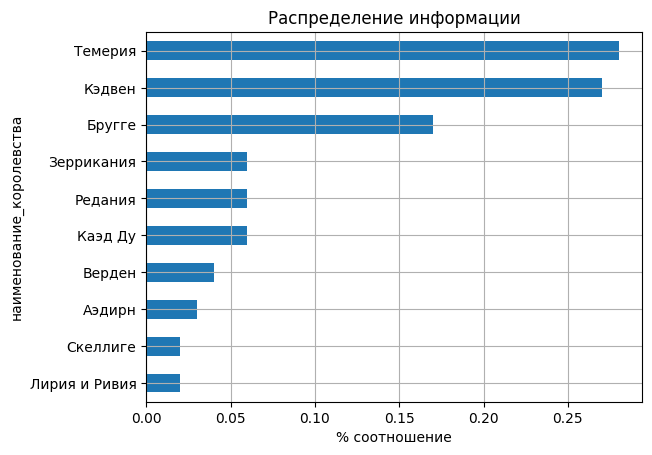

In [22]:
barh_column_hist('наименование_королевства', 'наименование_земли', tbl=True)

**Заключение:**
- есть королевства, данные по котором составляют очень малый объём от всей выборки;
- наибольший объём представляют три королевства;
- если малые данные сильно отличаются от большинства, это будет плохо сказываться на модель предсказания;

#### наименование_земли

Посмотрим на уникальность земель. Оценим интенсивность использования земель.

In [23]:
sorted_names = sorted(data_names['наименование_земли'].unique())
print(sorted_names, len(sorted_names))

['Аган', 'Агания', 'Ариголь', 'Арча', 'Арчвуд', 'Асом', 'Ачимор', 'Балалейка', 'Балейк', 'БалыкЗапад', 'Балыкс', 'БлижНовыйПортен', 'Ближнезимний', 'БроньЮг', 'Вайвай', 'ВайвайСевер', 'Валинт', 'Ватур', 'Вахт', 'Вингар', 'Вингах', 'Волынский', 'ВоргенЮг', 'Гарнич', 'Герасимово', 'Грейтвуд', 'Груб', 'Жагра', 'ЗападныйКарай', 'ЗападныйЛуг', 'ЗападныйМессо', 'ЗападныйТаркос', 'ЗападныйЧатыльк', 'ЗападныйЧистин', 'Землянич', 'Зимбрук', 'Ингол', 'Инин', 'Итурия', 'КалинаСевер', 'Калино', 'Камнемыс', 'КамнемысЮг', 'Капинор', 'Капитош', 'Карай', 'Карам', 'Карамов', 'Катыльг', 'Кетов', 'Киньям', 'КрайняяПустошь', 'Крапивин', 'Краснолен', 'Кувай', 'Кулгин', 'Ломов', 'Лугар', 'Лугин', 'Луговин', 'Лянг', 'Малопяткин', 'МалыйЮган', 'Мегион', 'Меретон', 'МессВосток', 'Мессоя', 'Муравлен', 'Мыгин', 'Мыхпа', 'Нагор', 'Негусь', 'НижнийВарт', 'Новин', 'Новосамар', 'НовыйЗарин', 'НовыйПокур', 'НовыйПортен', 'Нояр', 'ОбьЮг', 'Оленька', 'Оренбург', 'Орехвал', 'Останковое', 'Остров', 'ОстрогЮг', 'Отделив',

Земель представлено большое к-во, поэтому функция слегка модифицирована

,значения,проценты
наименование_земли,,
Приобия,2759,0.21
Вингар,1076,0.08
Мессоя,838,0.06
НовыйПортен,734,0.05
Оренбург,598,0.04
Вингах,562,0.04
Жагра,487,0.04
Тайлак,386,0.03
Ватур,351,0.03


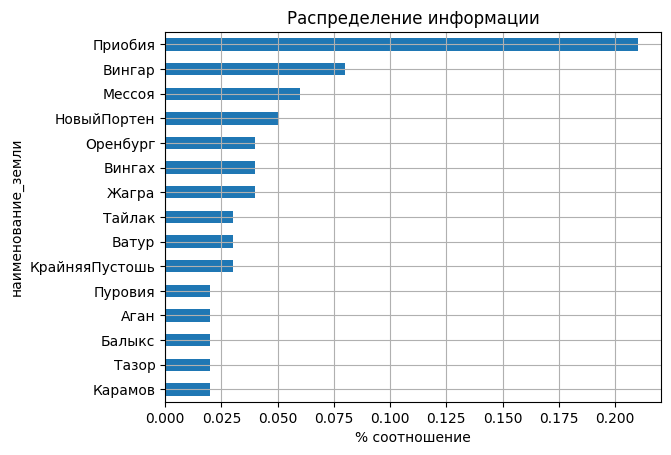

In [24]:
barh_column_hist('наименование_земли', 'наименование_королевства', limit = 0.01, tbl=True)

Оценим, используются ли некоторые земли в разных королевствах

In [25]:
un_lands = data_names['наименование_земли'].unique()
mask = lambda x: data_names.loc[data_names['наименование_земли'] == x, 'наименование_королевства'].unique()
{x: list(mask(x)) for x in un_lands if len(mask(x)) > 1}

{'Крапивин': ['Аэдирн', 'Верден'], 'Оренбург': ['Редания', 'Скеллиге']}

Можно оценить сколько раз обычно используется земля.

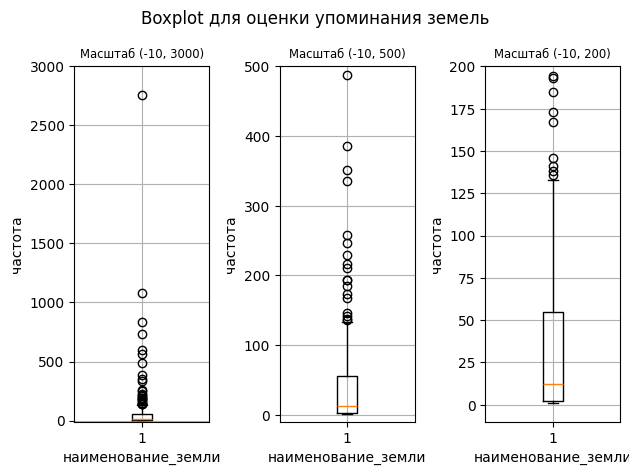

In [26]:
def box_name_land():
    def sutup_axes(num, rang):
        ax[num].boxplot(result)
        ax[num].grid()
        ax[num].set_ylim(rang)
        ax[num].set_title(f'Масштаб {rang}', fontsize=('small'))
        ax[num].set_ylabel('частота')
        ax[num].set_xlabel('наименование_земли')
        
    
    result = data_names['наименование_земли'].value_counts()
    fig, ax = plt.subplots(1, 3)
    fig.suptitle('Boxplot для оценки упоминания земель')
    
    sutup_axes(0, (-10, 3000))
    sutup_axes(1, (-10, 500))
    sutup_axes(2, (-10, 200))
    
    fig.tight_layout()


box_name_land()

**Заключение:**
- имена земель составные, менять не будем;
- пропусков не обнаружено;
- земли разбиты по королевствам, их много и нет каких-то больших групп. Стоит подуматьо важности этого признака;
- за некоторыми землями закреплено несколько королеств;
- ящик с усами указал на уже знакомы выбросы, но это не те выбросы от которых стоит избавляться;

#### наименование_хребта

Посмотрим на уникальность, оценим популярность. Проводить оценку на выбросы может быть не целесобразно. 

In [27]:
print(data_names['наименование_хребта'].unique()[:15])

['684' '1141' '18А.28' '9А.18' '627' '1190' '2179' '911' '1122' '1333'
 '23.2' '1688' '715' '3347' '734']


In [28]:
len(data_names['наименование_хребта'].unique())

703

703 уникальных значения

,значения,проценты
наименование_хребта,,
1333,311,0.02
1513,278,0.02
1916,268,0.02
715,267,0.02
1047,257,0.02
1688,253,0.02
А14,250,0.02
8717,217,0.02
923,188,0.01


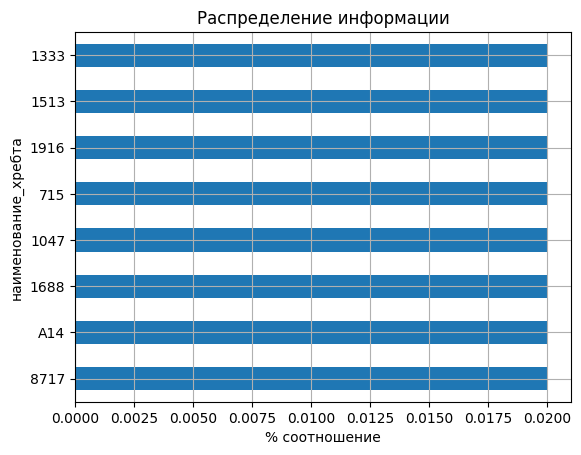

In [29]:
barh_column_hist('наименование_хребта', 'наименование_королевства', limit = 0.01, tbl=True)

Определённо некоторые хребты пользуются большим спросом. Интересно как это коррелирует с Приобией..\
Посмотрим на это распределение на гистограмме

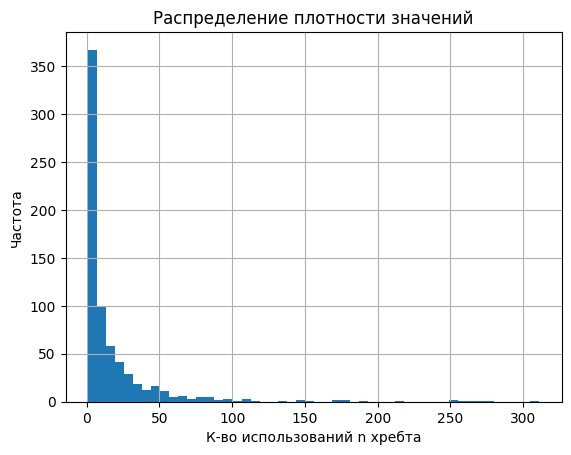

In [30]:
col_vc_hist('наименование_хребта', 'К-во использований n хребта');

**Заключение:**
- пока не ясно на сколько информация о наименовании хребта полезна, учитывая достаточно большую вариативность, можно предположить, что этот признак будет скорее мешать;
- скорее может иметь роль земли на которой находится n хребтов, от этого может зависеть сложность получения артефактов;

#### наименование_расщелины

Вероятно, что уникальность таких имен гораздо более выражена.

In [31]:
len(data_names['наименование_расщелины'].unique())

4947

In [32]:
data_names['наименование_расщелины'].value_counts().head(10)

наименование_расщелины
8258    29
4153    20
341     19
8050    19
5827    19
2573    18
1893    17
3669    17
5258    17
7325    17
Name: count, dtype: int64

Оценим на графике

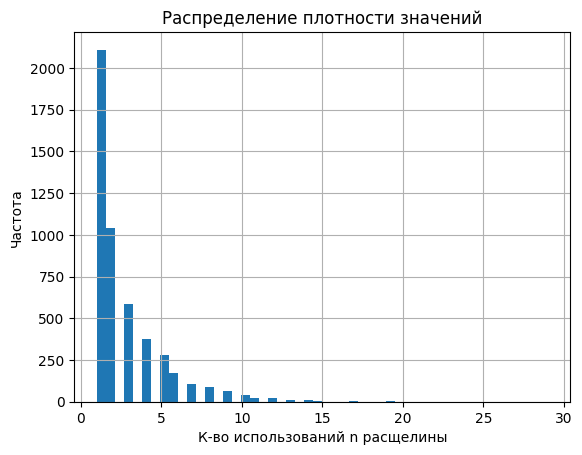

In [33]:
col_vc_hist('наименование_расщелины', 'К-во использований n расщелины');

In [34]:
data_names['наименование_расщелины'].value_counts().describe()

count    4947.000000
mean        2.711947
std         2.451079
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        29.000000
Name: count, dtype: float64

**Заключение**
- стоит попробовать привязать характеристики к расщелинам, чтобы понять есть ли разница между ними;
- можно достаточно грубо сказать, что наименование расщелин плавно распределено по датасету;

#### цель

По наименованию кажется, что этот признак более интересен, чем предидущие. Здесь действительно интересно найти уникальные значения. И провести оценку распределения.

In [35]:
data_names['цель'].unique()

array(['поиск', 'боковой отвилок', 'разведка'], dtype=object)

*всего три цели*

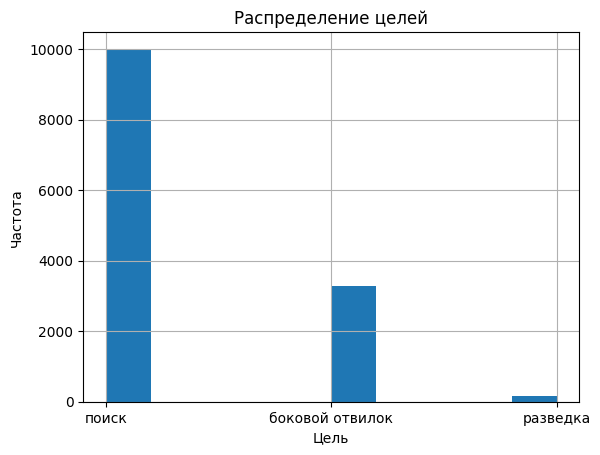

In [36]:
data_names['цель'].hist()
plt.title('Распределение целей')
plt.ylabel('Частота')
plt.xlabel('Цель');

In [37]:
print("Представим данные в процентном соотношении")
round(data_names['цель'].value_counts()/data_names.shape[0], 2)

Представим данные в процентном соотношении


цель
поиск              0.74
боковой отвилок    0.24
разведка           0.01
Name: count, dtype: float64

**Заключение:**
- признак цель содержит три уникальных ззначения:
   - поиск - 0.74 %;
   - боковой отвилок - 0.24 %;
   - разведка - 0.01 %;

#### тип_расщелины


Согласно методу `info` мы имеем в этом столбце 2 пропуска

In [38]:
data_names['тип_расщелины'].isna().sum()

2

Оценим уникальность

In [39]:
data_names['тип_расщелины'].unique()

array(['наклонная', 'горизонтальная', 'вертикальная', 'многощельная', nan],
      dtype=object)

,значения,проценты
тип_расщелины,,
горизонтальная,9141,0.68
наклонная,2834,0.21
многощельная,1293,0.10
вертикальная,146,0.01
NaN,2,0.00


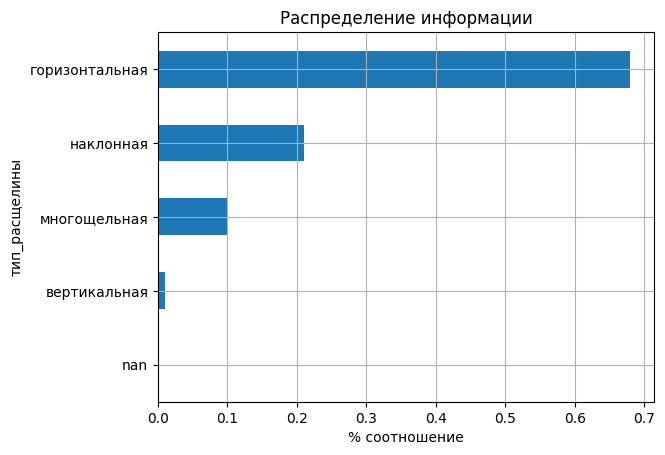

In [40]:
barh_column_hist('тип_расщелины', 'наименование_королевства', tbl = True)

**Заключение:**
- в столбце имеется 2 пропуска;
- очень мало данных представлено категорией `вертикальная` всего 0.01 %;
- было бы хорошо исследовать на корреляцию;

#### категория_расщелины

In [41]:
_ = data_names['категория_расщелины']

In [42]:
_.isna().sum()

0

0 пропусков

In [43]:
_.unique()

array(['Нагнетательная', 'Поисковая', 'Водозаборная', 'Поглощающая',
       'Разведочная', 'Поисково-оценочная', 'Прочее', 'Оценочная',
       'Пилот'], dtype=object)

,значения,проценты
категория_расщелины,,
Поисковая,12335,0.92
Нагнетательная,811,0.06
Поисково-оценочная,88,0.01
Разведочная,81,0.01
Водозаборная,78,0.01
Поглощающая,20,0.00
Прочее,1,0.00
Пилот,1,0.00
Оценочная,1,0.00


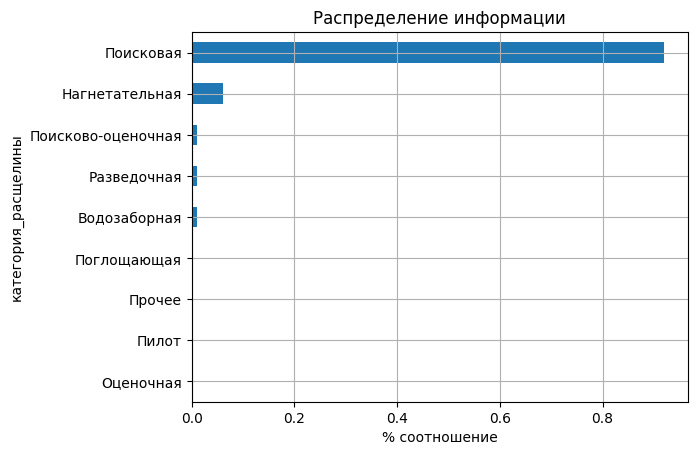

In [44]:
barh_column_hist('категория_расщелины', 'наименование_королевства', tbl = True)

**Заключение:**
- оставить категории `Поисковая`, `Нагнетательная`. Остальные убрать, так как их общий вклад в набор данных составляет меньше 0.04%;

#### назначение_расщелины

In [45]:
_ = data_names['назначение_расщелины']

Определим функцию для изучния и вывода информации по пропускам

In [46]:
def isna_user_info(column):
    is_nan = column.isna().sum()
    is_nan_perc = round(is_nan/data_names.shape[0], 2)
    print(f'Количество пропущенный значений: {is_nan} ({is_nan_perc}%)')

Посмотрим на пропуски

In [47]:
isna_user_info(_)

Количество пропущенный значений: 2616 (0.19%)


*надо попробовать восстановить эти значения*

Оценим распределение признаков

,значения,проценты
назначение_расщелины,,
Око Дракона,9999,0.75
NaN,2616,0.19
Магическое воздействие,665,0.05
Камень Судеб,132,0.01
Неизвестный Артефакт,3,0.00
Священная Амброзия,1,0.00


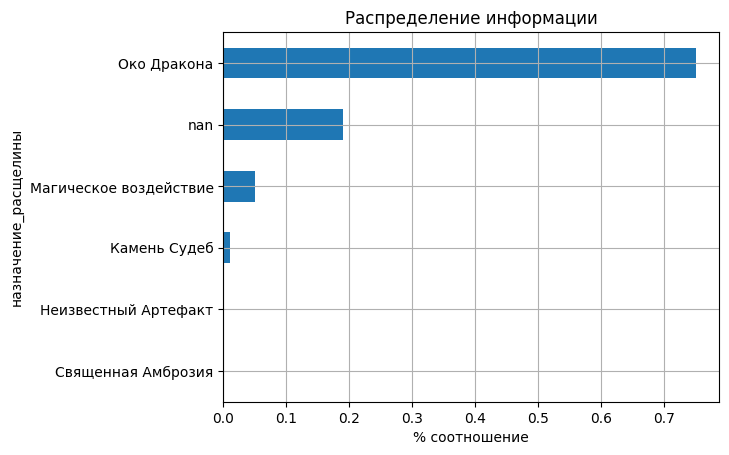

In [48]:
barh_column_hist('назначение_расщелины', 'наименование_королевства', tbl = True)

**Заключение**
- попробуем восстановить данные;
- мало значений представлено двумя категориями, выявить зависимость по ним будет сложно;
- категории 'Камень Судеб', 'Неизвестный Артефакт', 'Священная Амброзия' стоит убрать;
- количество пропущенный значений: 2616 (0.19%)

#### участки

In [49]:
_ = data_names['участки']

In [50]:
len(_.unique())

106

In [51]:
_.unique()

array(['верхнее укрепление+среднее укрепление+основное укрепление',
       'верхнее укрепление+среднее укрепление+основное укрепление+тупик',
       'тупик', 'верхнее укрепление+среднее укрепление',
       'среднее укрепление+основное укрепление',
       'верхнее укрепление+среднее укрепление+пилот+основное укрепление+тупик',
       'верхнее укрепление+основное укрепление', 'среднее укрепление',
       'верхнее укрепление+основное укрепление+тупик',
       'верхнее укрепление', nan,
       'верхнее укрепление+среднее укрепление+пилот+основное укрепление',
       'верхнее укрепление+среднее укрепление+тупик',
       'среднее укрепление+основное укрепление+тупик',
       'основное укрепление+тупик',
       'верхнее укрепление+среднее укрепление+пилот',
       'верхнее укрепление+среднее укрепление+среднее укрепление+основное укрепление',
       'верхнее укрепление+среднее укрепление+основное укрепление+основное укрепление',
       'пилот+основное укрепление+тупик',
       'верхнее укрепл

,значения,проценты
участки,,
верхнее укрепление+среднее укрепление+основное укрепление,2687,0.20
верхнее укрепление+среднее укрепление+основное укрепление+тупик,2681,0.20
тупик,2280,0.17
NaN,1736,0.13
среднее укрепление+основное укрепление+тупик,607,0.05
верхнее укрепление+среднее укрепление+пилот+основное укрепление+тупик,578,0.04
среднее укрепление+основное укрепление,484,0.04
среднее укрепление+пилот+основное укрепление+тупик,443,0.03
среднее укрепление+пилот+основное укрепление,424,0.03


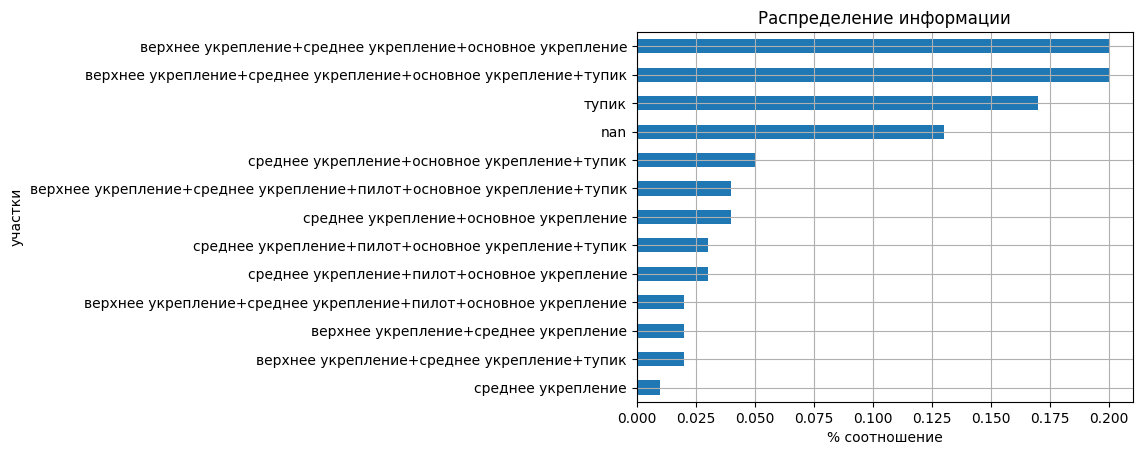

In [52]:
barh_column_hist('участки', 'наименование_королевства', tbl = True, limit=0.005)

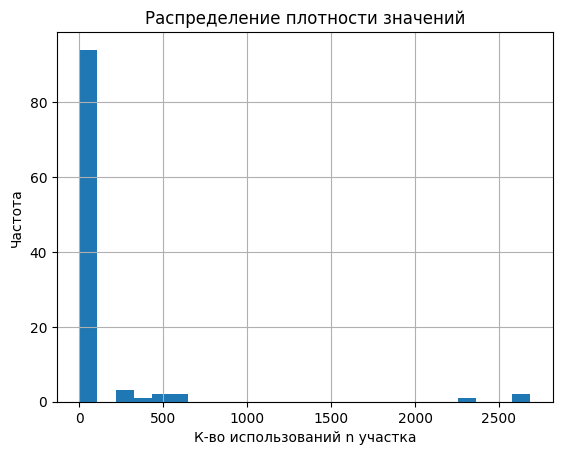

In [53]:
_.value_counts().hist(bins=25)
plt.title('Распределение плотности значений')
plt.xlabel('К-во использований n участка')
plt.ylabel('Частота');

**Заключение**
- 0.13% пропусков, которые стоит, либо восстановить, либо убрать, хотя 13% это достаточно много;
- много строк имеют свою характеристику, это хорошо;
- возможно будет наблюдаться корреляция со столбцом общий путь, если он представлен числовыми значениями, то лучше оставить его;
- подобные признаки можно использовать для расширения имеющихся, достаточно разбить по + наименования;

#### тип_отвилка

In [54]:
_ = data_names['тип_отвилка']

,значения,проценты
тип_отвилка,,
Материнский,7847,0.58
Боковой,2893,0.22
Материнский; Пилотный,1015,0.08
Дополнительный; Материнский,663,0.05
Дополнительный,353,0.03
NaN,208,0.02
Боковой; Пилотный,174,0.01
Дополнительный; Материнский; Пилотный,158,0.01
Боковой; Дополнительный,76,0.01


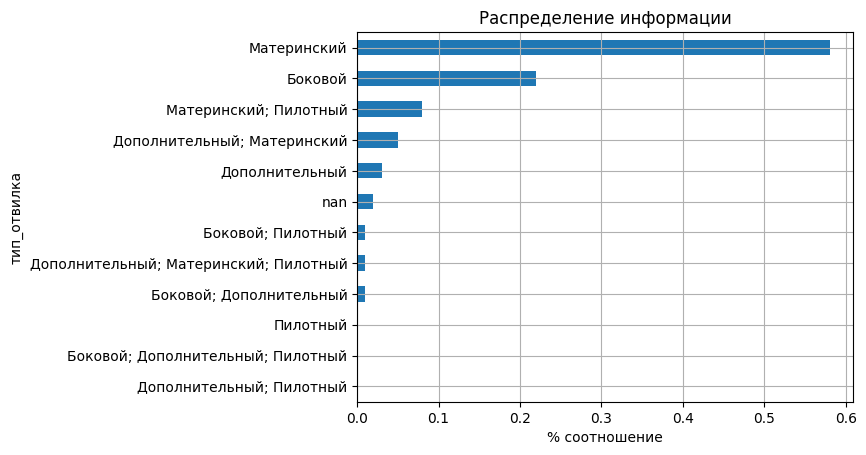

In [55]:
barh_column_hist('тип_отвилка', 'наименование_королевства', tbl = True)

*Здесь можно поиграть с объединением признаков, где значений мало*

**Заключение**
- уникальных значений не так много;
- некоторые категории можно попробовать объединить;
- пропусков всего 0.02;

#### технологическая_особенность

Судя по названию, может быть важным признаком

In [56]:
_ = data_names['технологическая_особенность']
len(_.unique())

149

In [57]:
_.unique()[:20]

array(['наклонная', 'горизонтальная + отвилков 40', 'горизонтальная',
       'горизонтальная + отвилков 60', 'вертикальная',
       'многощельная + отвилков 60', 'многощельная + отвилков 40',
       'многощельная', 'горизонтальная + отвилков 80',
       'наклонная + отвилков 40', 'наклонная + отвилков 40 + пилотов 40',
       'наклонная + отвилков 80',
       'горизонтальная + отвилков 40 + пилотов 20',
       'горизонтальная + отвилков 40 + магическое воздействие',
       'горизонтальная + пилотов 20', 'горизонтальная + пилотов 40',
       'многощельная + отвилков 40 + пилотов 20',
       'наклонная + пилотов 20', 'горизонтальная + пилотов 60',
       'наклонная + отвилков 60'], dtype=object)

,значения,проценты
технологическая_особенность,,
горизонтальная,4256,0.32
горизонтальная + комбинированное магическое воздействие,2490,0.19
наклонная,2088,0.16
горизонтальная + пилотов 20,703,0.05
горизонтальная + отвилков 40,600,0.04
многощельная + отвилков 40,463,0.03
наклонная + магическое воздействие,305,0.02
горизонтальная + пилотов 20 + комбинированное магическое воздействие,301,0.02
наклонная + пилотов 20,160,0.01


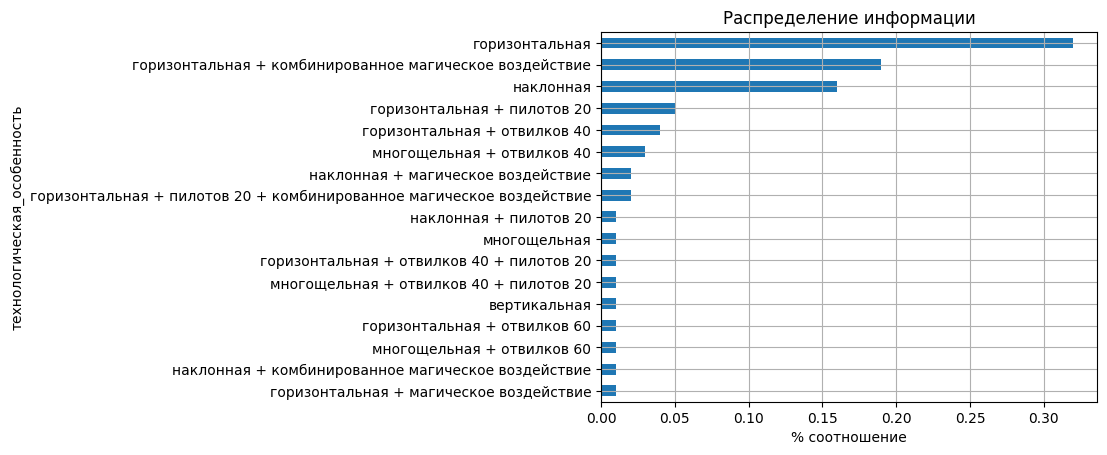

In [58]:
barh_column_hist('технологическая_особенность', 'наименование_королевства', tbl = True, limit=0.005)

In [59]:
round(_.value_counts()/data_names.shape[0], 2)[:15].sum()

0.9

In [60]:
isna_user_info(_)

Количество пропущенный значений: 2 (0.0%)


**Заключение**
- подобные признаки можно использовать для расширения имеющихся, достаточно разбить по + наименования;
- всего 2 пропуска;
- первые 15 признаков составляют 90% данных;

#### статус_поиска

In [61]:
_ = data_names['статус_поиска']
len(_.unique())

3

,значения,проценты
статус_поиска,,
завершен,12868,0.96
NaN,383,0.03
в процессе,165,0.01


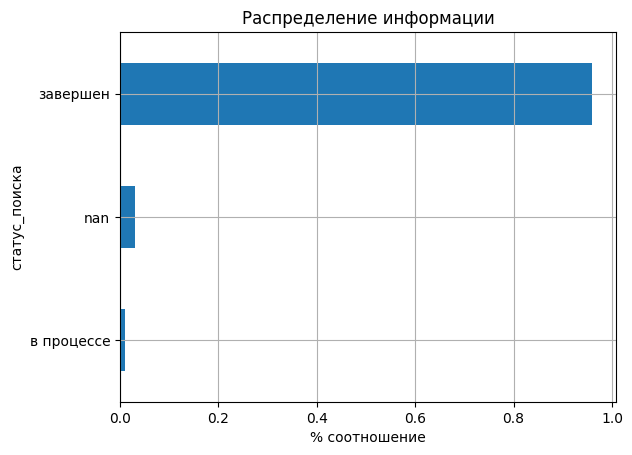

In [62]:
barh_column_hist('статус_поиска', 'наименование_королевства', tbl = True)

**Заключение**
- NaN может быть самым частым значением, можно попробовать восстановить по другим признакам;
- в процессе можно отбросить, чтобы это негативно не влияло на модель;

#### помощник_по_контролю_поиска

In [63]:
_ = data_names['помощник_по_контролю_поиска']
len(_.unique())

99

*Ого, 99 помошников и все разные!*

In [64]:
data_names['помощник_по_контролю_поиска'].value_counts().describe()

count      98.000000
mean      130.000000
std       378.395882
min         1.000000
25%         1.000000
50%         5.000000
75%        60.000000
max      2624.000000
Name: count, dtype: float64

,значения,проценты
помощник_по_контролю_поиска,,
Геральт и Компания,2624,0.20
АО Гильдия Техников,1869,0.14
ООО Ойл Сервис Гарант (Опасная Группировка),1276,0.10
Шрамы Хроноса,1046,0.08
Блоки и Загадки,834,0.06
Каэд Ду,753,0.06
NaN,676,0.05
Каменные Защитники,622,0.05
АО Золотая Орда,412,0.03


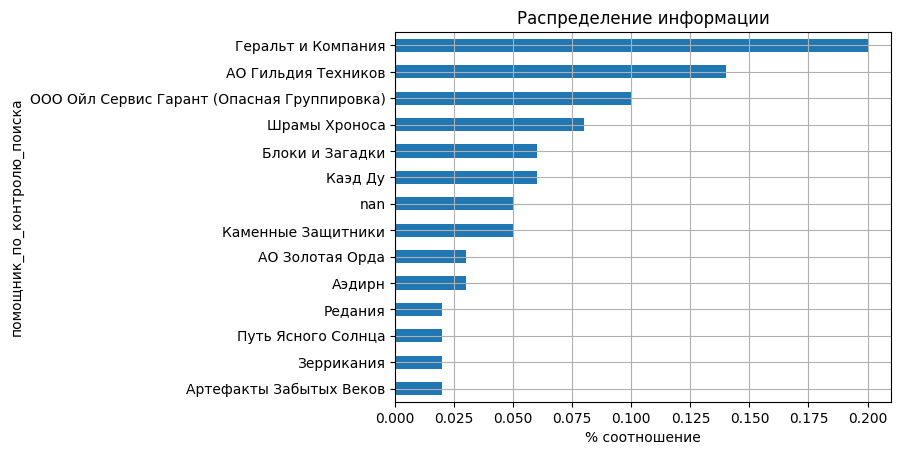

In [65]:
barh_column_hist('помощник_по_контролю_поиска', 'наименование_королевства', tbl=True, limit=0.01)

In [66]:
isna_user_info(_)

Количество пропущенный значений: 676 (0.05%)


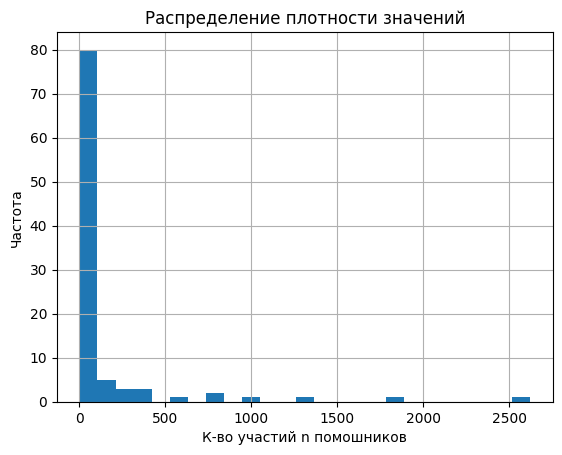

In [67]:
_.value_counts().hist(bins=25)
plt.title('Распределение плотности значений')
plt.xlabel('К-во участий n помошников')
plt.ylabel('Частота');

**Заключение**
- интересно как влияют помошники по контрою поиска на время поиска;
- 0.05% пропусков;

#### помощник_по_поиску

In [68]:
_ = data_names['помощник_по_поиску']
len(_.unique())

126

,значения,проценты
помощник_по_поиску,,
Магические Узы Бурь,1346,0.10
Кланы Восточных Рудников,1222,0.09
Наследие Громовой Кузницы,1168,0.09
Компания Глоруин,1068,0.08
Эмблема Звездных Странников,866,0.06
НФ Авангард Стихийных Кузниц,709,0.05
КФ Компания Глоруин,698,0.05
Управление Почтовых и Навигационных Дел Королевств Севера,513,0.04
Индивидуальные Друидские Силы,477,0.04


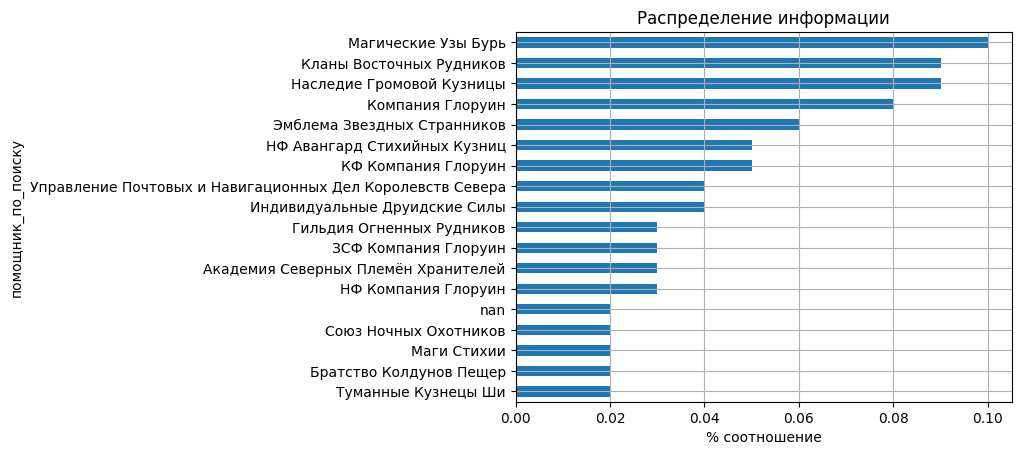

In [69]:
barh_column_hist('помощник_по_поиску', 'наименование_королевства', tbl=True, limit=0.01)

In [70]:
isna_user_info(_)

Количество пропущенный значений: 334 (0.02%)


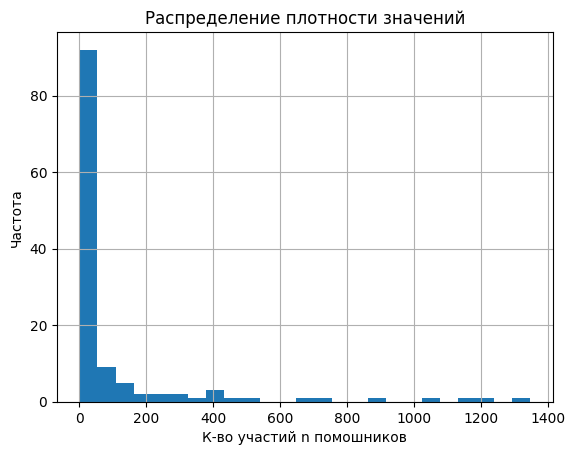

In [71]:
_.value_counts().hist(bins=25)
plt.title('Распределение плотности значений')
plt.xlabel('К-во участий n помошников')
plt.ylabel('Частота');

**Заключение**
- количество пропущенный значений: 334 (0.02%);
- наблюдается несколько наиболее многозадачных помошников, в основном же каждый помошник охватывает относительно небольшой набор данных;

#### помощник_по_наклонным_расщелинам

In [72]:
_ = data_names['помощник_по_наклонным_расщелинам']
len(_.unique())

230

In [73]:
_.unique()[:10]

array([nan,
       'Ковен Ветра и Бурения; Цех Технологического Геомагического Бурения',
       'Туманные Кузнецы Ши', 'Союз Геомагических Сервисов',
       'Цех Технических Дел Махакамской Крепости',
       'Краснолюдский Цех Буровых Технологий',
       'Сибирский Союз Магических Сервисов', 'Союз Бурильщиков Петра',
       'Цех Технологического Геомагического Бурения',
       'Авангард Стихийных Кузниц'], dtype=object)

,значения,проценты
помощник_по_наклонным_расщелинам,,
Краснолюдский Цех Буровых Технологий,2447,0.18
Ковен Ветра и Бурения,1522,0.11
Цех Технологического Геомагического Бурения,1314,0.10
Гильдия Новых Технологий,752,0.06
Союз Геомагических Сервисов,637,0.05
NaN,622,0.05
Альянс Сервисных Технологий,559,0.04
Навигационная Гильдия Мастеров Пути,542,0.04
Филиал Мастеров Халл,516,0.04


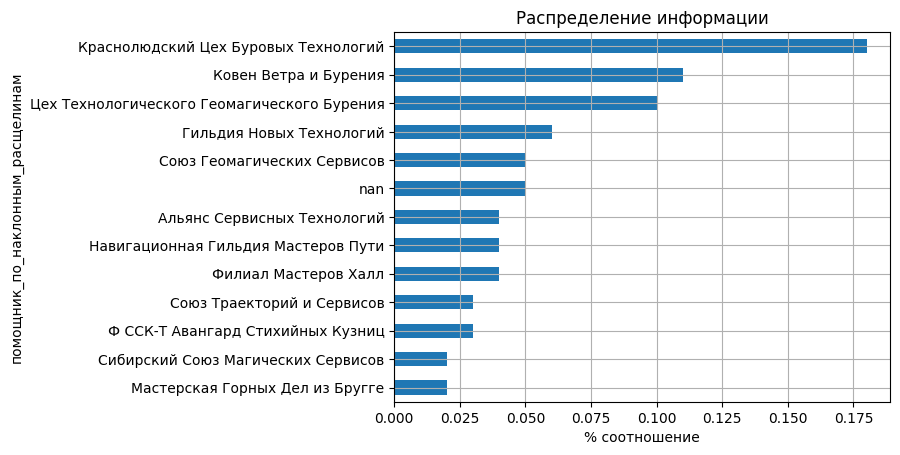

In [74]:
barh_column_hist('помощник_по_наклонным_расщелинам', 'наименование_королевства', tbl=True, limit=0.01)

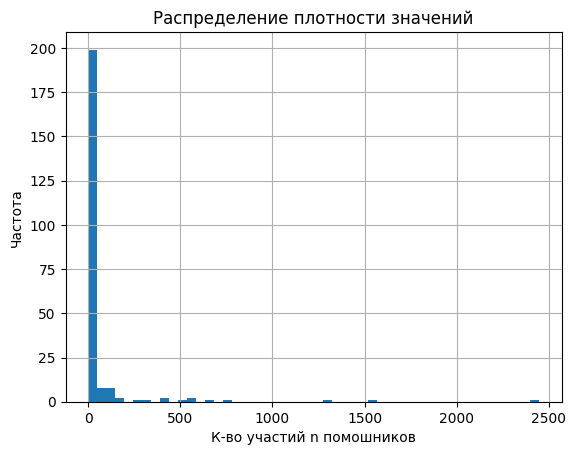

In [75]:
col_vc_hist('помощник_по_наклонным_расщелинам', 'К-во участий n помошников');

**Заключение**
- 0.05 % пропусков;
- данные должны иметь отношение ко времени выполнения работ;

#### помощник_по_зельям


In [76]:
_ = data_names['помощник_по_зельям']
len(_.unique())

87

In [77]:
_.unique()[:10]

array(['Краснолюдский Цех Буровых Технологий',
       'Альянс Мудрецов и Травников Нильфгаарда', 'Туманные Кузнецы Ши',
       nan, 'Гильдия Инженеров Петро',
       'Лоджия Мастеров Службы Бурения, Институт Магических Исследований',
       'Гильдия Сервисных РаботТЭК-Бурение',
       'Альянс Мудрецов и Травников Нильфгаарда; Краснолюдский Цех Буровых Технологий',
       'Специальная Служба Петра (ООО СПС)', 'Печать Грозового Рога'],
      dtype=object)

,значения,проценты
помощник_по_зельям,,
Альянс Хранителей Рун,2402,0.18
Гильдия Инженеров Петро,2239,0.17
Туманные Кузнецы Ши,1491,0.11
Альянс Мудрецов и Травников Нильфгаарда,1146,0.09
Специальная Служба Петра (ООО СПС),898,0.07
Краснолюдский Цех Буровых Технологий,891,0.07
Филиал Мастеров Халл,844,0.06
NaN,577,0.04
Нордский Союз Конструкторов,348,0.03


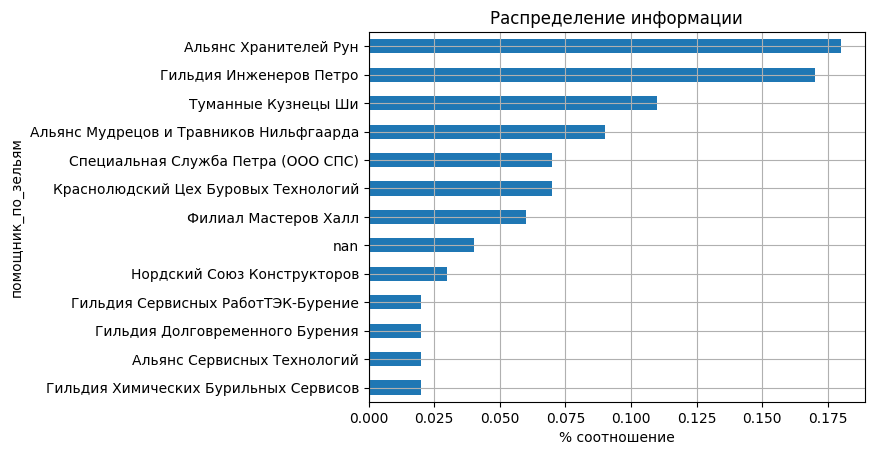

In [78]:
barh_column_hist('помощник_по_зельям', 'наименование_королевства', tbl=True, limit=0.01)

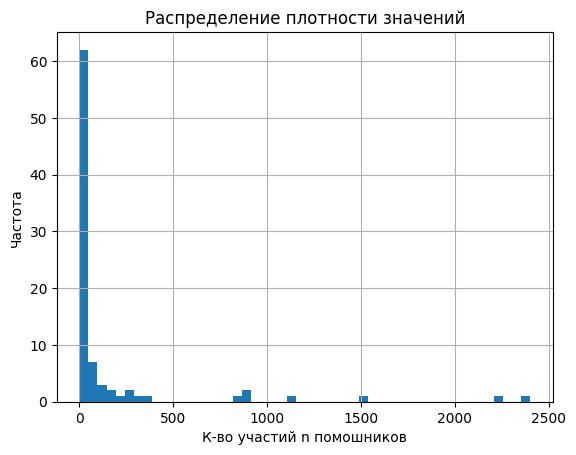

In [79]:
col_vc_hist('помощник_по_зельям', 'К-во участий n помошников');

**Заключение**
- 0.04 % пропусков;

#### помощник_по_долбилам

In [80]:
_ = data_names['помощник_по_долбилам']
len(_.unique())

122

,значения,проценты
помощник_по_долбилам,,
Краснолюдский Цех Буровых Технологий,4786,0.36
Гильдия Новых Технологий,2479,0.18
АО НПП Защитники Проклятых,1344,0.10
Гильдия Нефтяных Полей Востока,731,0.05
NaN,680,0.05
Пантеон Туманных Лезвий,384,0.03
Навигационная Гильдия Мастеров Пути,314,0.02
"Лоджия Мастеров Службы Бурения, Институт Магических Исследований",211,0.02
Управление Почтовых и Навигационных Дел Королевств Севера,183,0.01


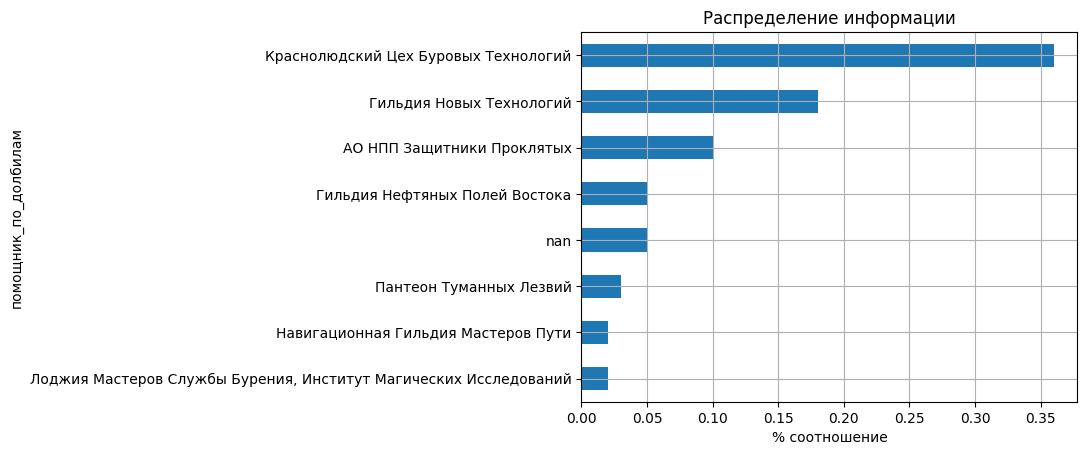

In [81]:
barh_column_hist('помощник_по_долбилам', 'наименование_королевства', tbl=True, limit=0.01)

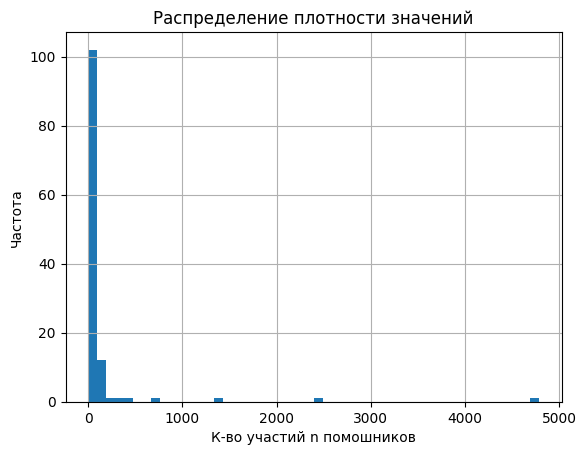

In [82]:
col_vc_hist('помощник_по_долбилам', 'К-во участий n помошников');

**Заключение**
- 5 % пропусков, стоит обратить внимание на похожие столбцы, вероятно пропуски везде в одинаковых строчках;

#### помощник_по_исследованиям

In [83]:
_ = data_names['помощник_по_исследованиям']
len(_.unique())

82

,значения,проценты
помощник_по_исследованиям,,
Гильдия Временных Исследований,2271,0.17
Гильдия Нефтяных Газпрома,1947,0.15
NaN,1371,0.10
Гильдия Технологий и Инноваций,1284,0.10
Гильдия Новых Геоисследований,1250,0.09
Стихия,961,0.07
Гильдия Паритетных Служб,724,0.05
Цех Горняков Речных Разрезов Каэдвена,556,0.04
Гильдия Геосервисов и Помощи,434,0.03


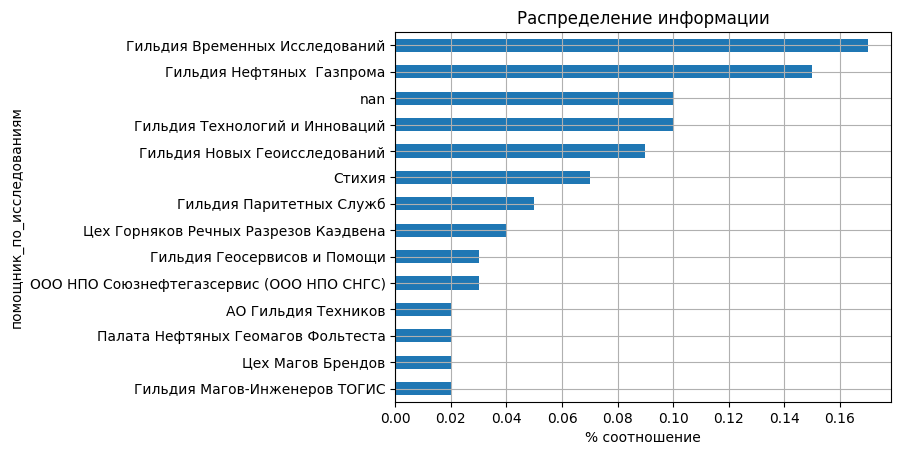

In [84]:
barh_column_hist('помощник_по_исследованиям', 'наименование_королевства', tbl=True, limit=0.01)

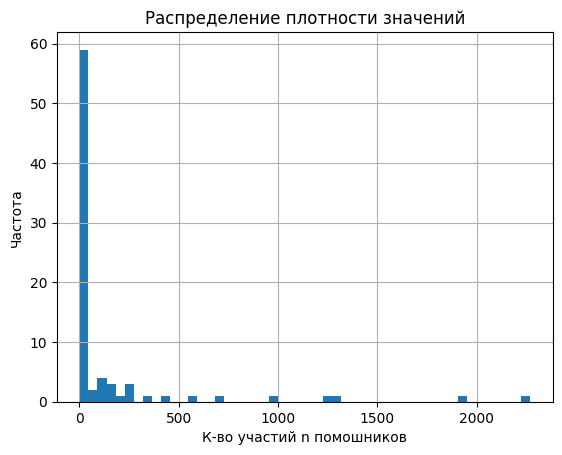

In [85]:
col_vc_hist('помощник_по_исследованиям', 'К-во участий n помошников');

**Заключение**
- 10% пропусков;

#### помощник_по_укреплению

In [86]:
len(data_names['помощник_по_укреплению'].unique())

187

In [87]:
data_names['помощник_по_укреплению'].unique()[:10]

array(['Искусство Стихийных Служб', 'Магическая Торговая Управа',
       'Строительный Технический Ковен',
       'Искусство Стихийных Служб; Строительный Технический Ковен', nan,
       'Энергетическая Служба Редании',
       'Искусство Стихийных Служб; Энергетическая Служба Редании',
       'Туманные Кузнецы Ши', 'Сибирская Крепостная Служба',
       'Ковен Ветра и Бурения; Искусство Стихийных Служб; Энергетическая Служба Редании'],
      dtype=object)

,значения,проценты
помощник_по_укреплению,,
Служба Контроля Природных Недр,2955,0.22
NaN,1881,0.14
Искусство Стихийных Служб,1300,0.10
Филиал Мастеров Халл,1134,0.08
Северный Сервисный Альянс,749,0.06
Торговая Служба Интеко,574,0.04
Альянс Сервисных Технологий,423,0.03
Авангард Стихийных Кузниц,400,0.03
Сибирская Крепостная Служба,322,0.02


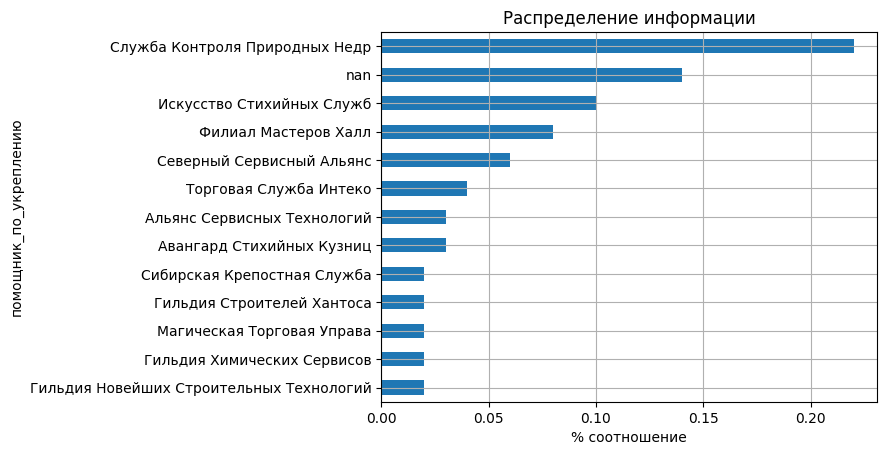

In [88]:
barh_column_hist('помощник_по_укреплению', 'наименование_королевства', tbl=True, limit=0.01)

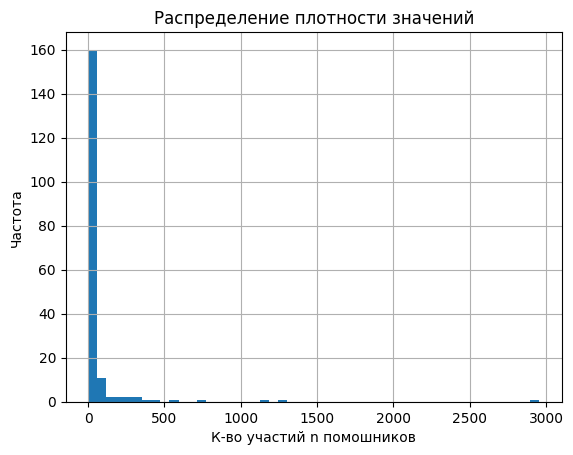

In [89]:
col_vc_hist('помощник_по_укреплению', 'К-во участий n помошников');

**Заключение**
- 14 % пропусков, лучше восстановить;

#### помощник_по_огненным_заклятиям

In [90]:
len(data_names['помощник_по_огненным_заклятиям'].unique())

80

,значения,проценты
помощник_по_огненным_заклятиям,,
Гильдия Нефтяных Газпрома,6348,0.47
NaN,5294,0.39
Палата Нефтяных Геомагов Фольтеста,540,0.04
Промышленная Гильдия Земляных Магов Тимерии,295,0.02
Технический Гильдийный Геомагический Фонд,197,0.01
Гильдия Магов-Инженеров ТОГИС,161,0.01
АО Ноябрьские Мудрецы,94,0.01
Орден Нефтяных Геомагов Оренбурга,55,0.00
Союз Русских Геосервисов,38,0.00


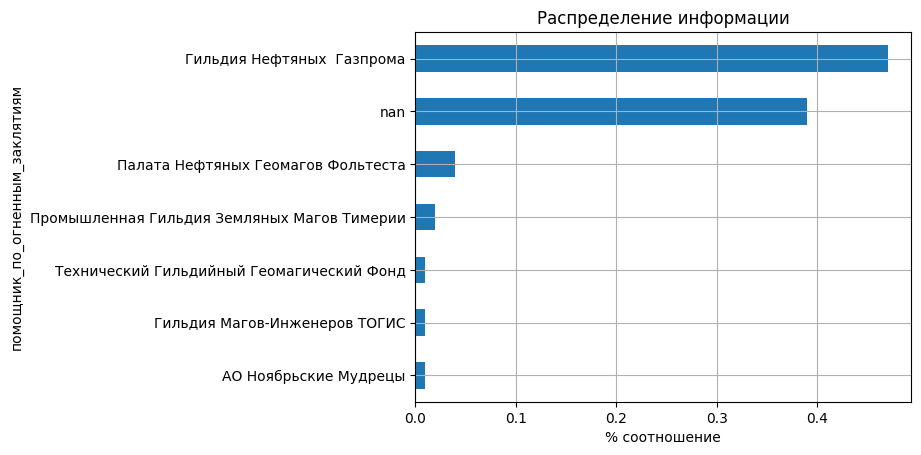

In [91]:
barh_column_hist('помощник_по_огненным_заклятиям', 'наименование_королевства', tbl=True, limit=0.001)

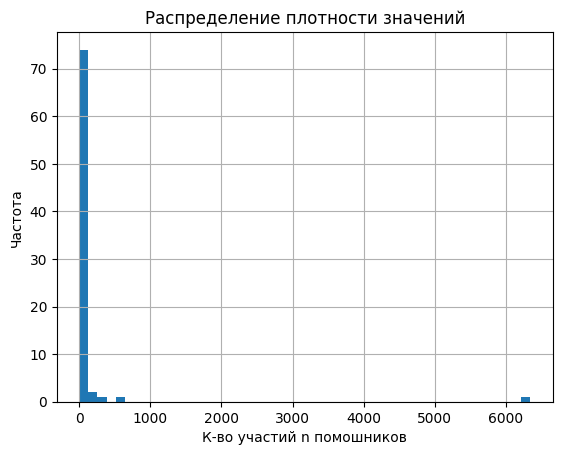

In [92]:
col_vc_hist('помощник_по_огненным_заклятиям', 'К-во участий n помошников');

**Заключение**
- очень много пропусков;
- пропуски могут быть оставлены по тех.ошибке, либо нет данных, так как это `Гильдия Нефтяных Газпрома`, либо просто  помошников не было;

#### помощник_по_подвескам

In [93]:
len(data_names['помощник_по_подвескам'].unique())

117

In [94]:
data_names['помощник_по_подвескам'].unique()[:10]

array([nan,
       'Лоджия Мастеров Службы Бурения, Институт Магических Исследований',
       'Ковен Ветра и Бурения', 'Научный Центр Земных Ресурсов',
       'Цех Тяжелых Пресс-машин', 'Технический Союз Сервисов',
       'Краснолюдский Цех Буровых Технологий',
       'Мастерская Внедрения Нефтяных Машин Туссента',
       'Гильдия Инженеров Петро', 'Мастерская Зенитного Колеса Новиграда'],
      dtype=object)

,значения,проценты
помощник_по_подвескам,,
NaN,7291,0.54
Научный Центр Земных Ресурсов,1286,0.10
Технический Союз Сервисов,1048,0.08
Альянс Зенитных Мастеров-Сервис,881,0.07
Гильдия Новых Технологий,694,0.05
Ковен Ветра и Бурения,388,0.03
Мастерская Сибирских Бурильных Машин,344,0.03
"Фонд Ковенов Бурения, Институт Магических Исследований",201,0.01
"Лоджия Мастеров Службы Бурения, Институт Магических Исследований",182,0.01


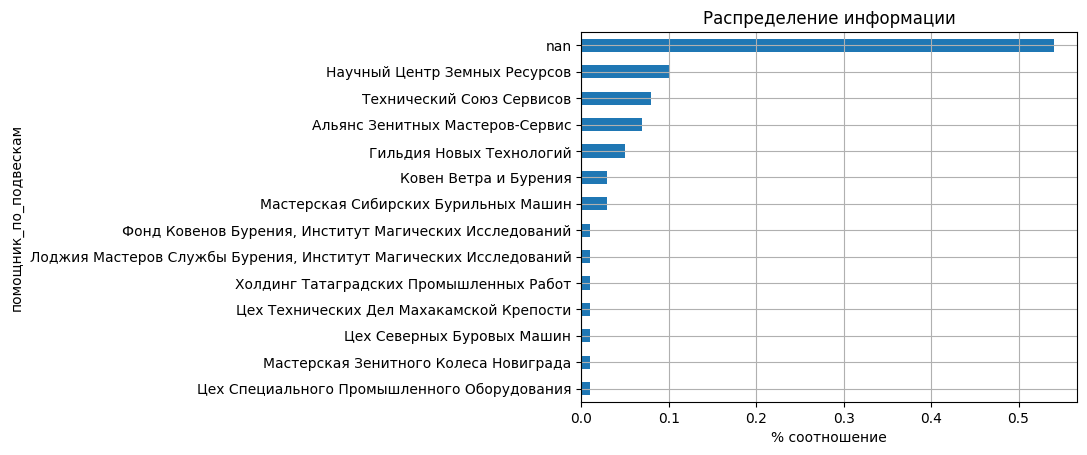

In [95]:
barh_column_hist('помощник_по_подвескам', 'наименование_королевства', tbl=True, limit=0.001)

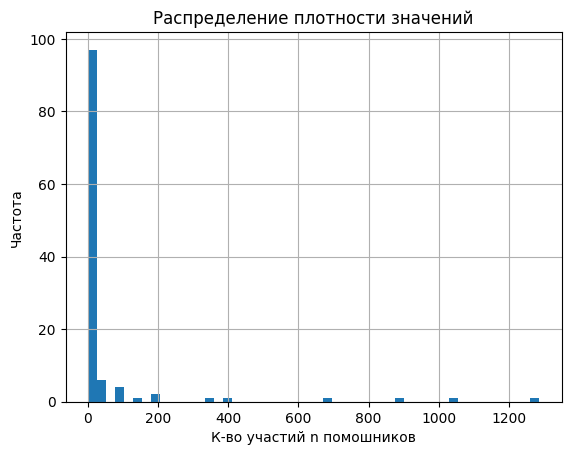

In [96]:
col_vc_hist('помощник_по_подвескам', 'К-во участий n помошников');

**Заключение**
- 54% пропущенных значений, вероятно помошников просто не было;

#### помощник_по_вырезке_окна

In [97]:
len(data_names['помощник_по_вырезке_окна'].unique())

25

Ого, как мало!

In [98]:
data_names['помощник_по_вырезке_окна'].unique()

array([nan, 'Краснолюдский Цех Буровых Технологий',
       'Защитники Проклятых ЗБС', 'АО НПП Защитники Проклятых',
       'АО НПП Защитники Проклятых; Краснолюдский Цех Буровых Технологий',
       'Гильдия Нефтяных Буровых Кузнецов',
       'Сервисная Гильдия Торговцев Сибиллы',
       'Институт Современных Технологий',
       'Цех Технических Дел Махакамской Крепости',
       'Союз Ночных Охотников', 'Цех Технологий Оксенфурта',
       'Гильдия Гироскопов и Геотехники',
       'Навигационная Гильдия Мастеров Пути', 'Кланы Восточных Рудников',
       'Гильдия Современных Технологий', 'Гильдия Инновационных Бурений',
       'Холдинг Петровских Газовых Технологий',
       'Защитники Проклятых ЗБС; Магическая Лаборатория Решений',
       'Сервисный Цех Глубоких Шахт Ковира',
       'Сервисный Цех Глубоких Шахт Ковира; Краснолюдский Цех Буровых Технологий',
       'Сервисный Цех Глубоких Шахт Ковира; Защитники Проклятых ЗБС',
       'АО НПП Защитники Проклятых; Цех Технологий Оксенфурта',

,значения,проценты
помощник_по_вырезке_окна,,
NaN,11860,0.88
Защитники Проклятых ЗБС,656,0.05
Краснолюдский Цех Буровых Технологий,535,0.04
АО НПП Защитники Проклятых,162,0.01
Институт Современных Технологий,42,0.00
Гильдия Современных Технологий,38,0.00
Сервисный Цех Глубоких Шахт Ковира,35,0.00
Гильдия Гироскопов и Геотехники,24,0.00
Цех Технологий Оксенфурта,17,0.00


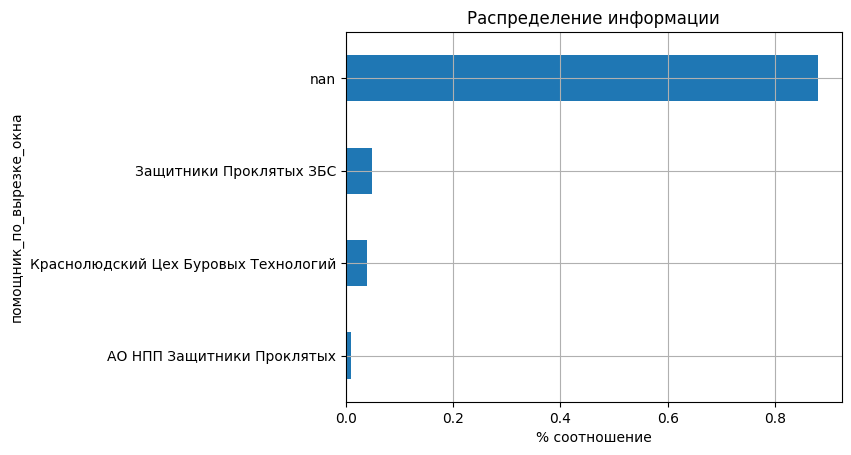

In [99]:
barh_column_hist('помощник_по_вырезке_окна', 'наименование_королевства', tbl=True, limit=0.001)

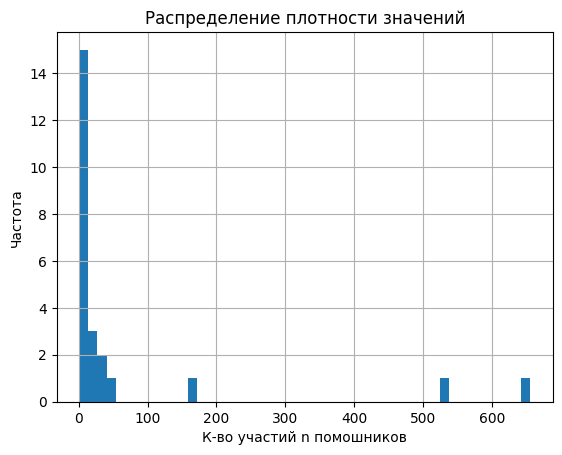

In [100]:
col_vc_hist('помощник_по_вырезке_окна', 'К-во участий n помошников');

**Заключение**
- столбец мало информативен;

#### тип_инструмента

In [101]:
len(data_names['тип_инструмента'].unique())

59

In [102]:
data_names['тип_инструмента'].unique()[:10]

array([nan, 'Кувалда-33', 'Кайло-38', 'Кирка-71', 'Кувалда-01',
       'Кувалда-55', 'Кайло-30S', 'Кирка-700', 'Кувалда-500', 'Кайло-32'],
      dtype=object)

*ТА вот где встречаются те самые иностранные символы*

,значения,проценты
тип_инструмента,,
NaN,13123,0.98
Кувалда-55,61,0.00
Кайло-38,27,0.00
Кувалда-L,25,0.00
Кирка-78,17,0.00
Кувалда-XXL,14,0.00
Кирка-71,10,0.00
Кувалда-54,10,0.00
Кирка-700,9,0.00


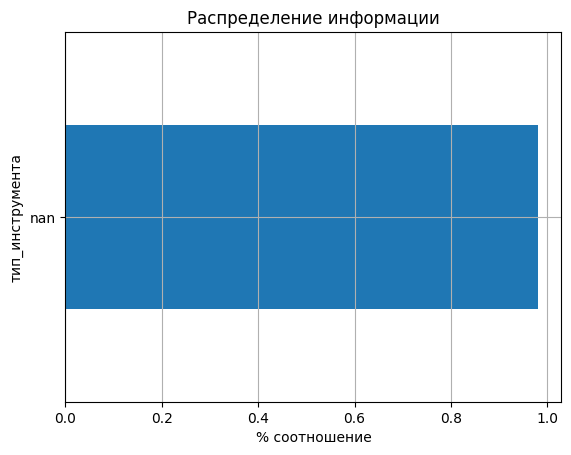

In [103]:
barh_column_hist('тип_инструмента', 'наименование_королевства', tbl=True, limit=0.001)

**Заключение**
- как видно механические способы поиска артефактов не очень популярны, гораздо более эффективны магические;

#### Коррелиция

Для изучения корреляции категориальных признаков проведём их преобразование.


In [104]:
data_names.head()

,наименование_королевства,наименование_земли,наименование_хребта,наименование_расщелины,цель,тип_расщелины,категория_расщелины,назначение_расщелины,участки,тип_отвилка,...,помощник_по_поиску,помощник_по_наклонным_расщелинам,помощник_по_зельям,помощник_по_долбилам,помощник_по_исследованиям,помощник_по_укреплению,помощник_по_огненным_заклятиям,помощник_по_подвескам,помощник_по_вырезке_окна,тип_инструмента
0,Кэдвен,Приобия,684,2903,поиск,наклонная,Нагнетательная,Магическое воздействие,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Компания Глоруин,NaN,Краснолюдский Цех Буровых Технологий,NaN,Гильдия Временных Исследований,Искусство Стихийных Служб,NaN,NaN,NaN,NaN
1,Темерия,Сутор,1141,1332,поиск,горизонтальная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,...,NaN,Ковен Ветра и Бурения; Цех Технологического Ге...,Альянс Мудрецов и Травников Нильфгаарда,Гильдия Новых Технологий,Стихия,Магическая Торговая Управа,NaN,NaN,NaN,NaN
2,Кэдвен,Приобия,18А.28,1027,поиск,наклонная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Компания Глоруин,Туманные Кузнецы Ши,Краснолюдский Цех Буровых Технологий,АО НПП Защитники Проклятых,NaN,Строительный Технический Ковен,NaN,NaN,NaN,NaN
3,Кэдвен,Приобия,9А.18,4208,поиск,наклонная,Поисковая,NaN,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Туманные Кузнецы Ши,Туманные Кузнецы Ши,Краснолюдский Цех Буровых Технологий,АО НПП Защитники Проклятых,NaN,Строительный Технический Ковен,NaN,NaN,NaN,NaN
4,Кэдвен,Приобия,627,9352,поиск,наклонная,Нагнетательная,Магическое воздействие,верхнее укрепление+среднее укрепление+основное...,Материнский,...,Туманные Кузнецы Ши,Союз Геомагических Сервисов,Туманные Кузнецы Ши,Краснолюдский Цех Буровых Технологий,NaN,Искусство Стихийных Служб; Строительный Технич...,NaN,NaN,NaN,NaN


В таблцице представлены все категориальные признаки, поэтому размерность нам не важна.

Определим функцию для преобразования

In [122]:
[*np.arange(0.1, 0.8, 0.1)]

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001]

In [164]:
def categorical_to_numeric(column):
    unique_value = column.unique()
    coeff = list(data_names.columns).index('наименование_земли')
    expression = -(len(str(1/2**coeff).split('.')[1]))
    step = 10 ** expression
    end = coeff + step * len(unique_value)
    dct = dict(zip(unique_value, [10 ** expression + i for i in np.arange(1/2**coeff, end, step)]))
    res = column.map(dct)
    return res


data_names_num = data_names.progress_apply(categorical_to_numeric, axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 490.67it/s]


In [165]:
data_names_num.head()

,наименование_королевства,наименование_земли,наименование_хребта,наименование_расщелины,цель,тип_расщелины,категория_расщелины,назначение_расщелины,участки,тип_отвилка,...,помощник_по_поиску,помощник_по_наклонным_расщелинам,помощник_по_зельям,помощник_по_долбилам,помощник_по_исследованиям,помощник_по_укреплению,помощник_по_огненным_заклятиям,помощник_по_подвескам,помощник_по_вырезке_окна,тип_инструмента
0,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,...,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6
1,0.7,0.7,0.7,0.7,0.6,0.7,0.7,0.7,0.7,0.6,...,0.7,0.7,0.7,0.7,0.7,0.7,0.6,0.6,0.6,0.6
2,0.6,0.6,0.8,0.8,0.6,0.6,0.7,0.7,0.6,0.6,...,0.6,0.8,0.6,0.8,0.8,0.8,0.6,0.6,0.6,0.6
3,0.6,0.6,0.9,0.9,0.6,0.6,0.7,0.7,0.6,0.6,...,0.8,0.8,0.6,0.8,0.8,0.8,0.6,0.6,0.6,0.6
4,0.6,0.6,1.0,1.0,0.6,0.6,0.6,0.6,0.6,0.6,...,0.8,0.9,0.8,0.9,0.8,0.9,0.6,0.6,0.6,0.6


In [166]:
data_names_num['наименование_королевства'].unique()

array([0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5])

In [112]:
list(data_names.columns).index('наименование_земли')

1

In [154]:
coef = 0.125
va = -(len(str(coef).split('.')[1])) 
dota = 10 ** va
end = coef + dota * len(unique())
for i in range(coef, end, dota):
    print(i)

0.001

In [157]:
0.125 + 10 ** 10 ** va

1.1273052380778996

In [161]:
0.125 + (10 ** va) * 10 

0.135

In [119]:
for i in range(10):
    print(1/2**i)

1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125


In [106]:
data_names_num.corr()

,наименование_королевства,наименование_земли,наименование_хребта,наименование_расщелины,цель,тип_расщелины,категория_расщелины,назначение_расщелины,участки,тип_отвилка,...,помощник_по_поиску,помощник_по_наклонным_расщелинам,помощник_по_зельям,помощник_по_долбилам,помощник_по_исследованиям,помощник_по_укреплению,помощник_по_огненным_заклятиям,помощник_по_подвескам,помощник_по_вырезке_окна,тип_инструмента
наименование_королевства,1.000000,1.000000,-0.353553,-0.353553,NaN,1.000000,0.408248,0.408248,1.000000,NaN,...,0.000000,-0.294174,0.250000,-0.294174,-0.250000,-0.294174,NaN,NaN,NaN,NaN
наименование_земли,1.000000,1.000000,-0.353553,-0.353553,NaN,1.000000,0.408248,0.408248,1.000000,NaN,...,0.000000,-0.294174,0.250000,-0.294174,-0.250000,-0.294174,NaN,NaN,NaN,NaN
наименование_хребта,-0.353553,-0.353553,1.000000,1.000000,NaN,-0.353553,0.000000,0.000000,-0.353553,NaN,...,0.790569,0.970725,0.530330,0.970725,0.883883,0.970725,NaN,NaN,NaN,NaN
наименование_расщелины,-0.353553,-0.353553,1.000000,1.000000,NaN,-0.353553,0.000000,0.000000,-0.353553,NaN,...,0.790569,0.970725,0.530330,0.970725,0.883883,0.970725,NaN,NaN,NaN,NaN
цель,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
тип_расщелины,1.000000,1.000000,-0.353553,-0.353553,NaN,1.000000,0.408248,0.408248,1.000000,NaN,...,0.000000,-0.294174,0.250000,-0.294174,-0.250000,-0.294174,NaN,NaN,NaN,NaN
категория_расщелины,0.408248,0.408248,0.000000,0.000000,NaN,0.408248,1.000000,1.000000,0.408248,NaN,...,0.000000,0.080064,-0.408248,0.080064,0.408248,0.080064,NaN,NaN,NaN,NaN
назначение_расщелины,0.408248,0.408248,0.000000,0.000000,NaN,0.408248,1.000000,1.000000,0.408248,NaN,...,0.000000,0.080064,-0.408248,0.080064,0.408248,0.080064,NaN,NaN,NaN,NaN
участки,1.000000,1.000000,-0.353553,-0.353553,NaN,1.000000,0.408248,0.408248,1.000000,NaN,...,0.000000,-0.294174,0.250000,-0.294174,-0.250000,-0.294174,NaN,NaN,NaN,NaN
тип_отвилка,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
data_names_cor = data_names_num.corr()
for num, col in enumerate(data_names_cor[1:]):
    print(col)
    for ind in data_names_cor.columns[:num]:
        val = data_names_cor.loc[ind, col]
        if abs(val) > 0.5: 
            print(ind, data_names_cor.loc[ind, col])
        
    print()


наименование_королевства

наименование_земли
наименование_королевства 1.0

наименование_хребта

наименование_расщелины
наименование_хребта 1.0

цель

тип_расщелины
наименование_королевства 1.0
наименование_земли 1.0

категория_расщелины

назначение_расщелины
категория_расщелины 1.0

участки
наименование_королевства 1.0
наименование_земли 1.0
тип_расщелины 1.0

тип_отвилка

технологическая_особенность
наименование_королевства 1.0
наименование_земли 1.0
тип_расщелины 1.0
участки 1.0

статус_поиска

помощник_по_контролю_поиска
категория_расщелины 0.6123724356957945
назначение_расщелины 0.6123724356957945

помощник_по_поиску
наименование_хребта 0.7905694150420948
наименование_расщелины 0.7905694150420948
помощник_по_контролю_поиска -0.5590169943749475

помощник_по_наклонным_расщелинам
наименование_хребта 0.9707253433941511
наименование_расщелины 0.9707253433941511
помощник_по_поиску 0.657793514480272

помощник_по_зельям
наименование_хребта 0.5303300858899107
наименование_расщелины 0.530330

In [ ]:
data_names_cor.reset_index()

In [ ]:
def pr_corr(data_corr):
    """
    Функция для нахождения
    наиболее коррелирующих признаков
    из таблицы корреляции
    """
    
    print(f'Столбец{"":<10}Строка{"":<10}Значение')
    for el in data_corr.columns:
        for var in data_corr[el]:
            if var > 0.1 and var < 1:
                print(f'{el :<16} {data_corr[el][data_corr[el] == var].index[0] :<14} {var :.05}')

                
pr_corr(data_names_num.corr())

#### Вывод

Проведён общий осмотр, мы познакомились с распределением данных и их представлением, выявили пропуски и нашли малочисленные признаки.
- обработаны пустые значения, представленные как одиночный символ пробела ' ', заменены на nan;
- столбцы с наименованием:
    - оставлены для восстановления значения в столбце `наименование_хребта`, представленные как nan1;
    - стоит поэксперементировать со столбцами 'наименование_королевства', 'наименование_земли', 'наименование_хребта', 'наименование_расщелины'. Возможно стоит оставить один или два из имеющихся из-за их более-менее нормального распределения. Cтолбец 'наименование_расщелины' делится на наименование_хребта и так далее, являясь самой простой категорией;
- цель - разбит на 3 категории:
    - поиск - 74% данных;
    - боковой отвилок - 24% данных;
    - разведка 1% данных;
    - последнюю можно убрать;
- тип_расщелины - имеет 4 категории, две из которых малозначительны:
    - горизонтальная - 68% данных;
    - наклонная - 21% данных;
    - многощельная - 10% данных;
    - вертикальная - 1% данных;
    - стоит ли говорить о плохом распределении данных?
- категория_расшелины - имеет несколько сильно выраженных признаков, остальные составляют малую часть:
    - поисковая	92%;
    - нагнетательная 6%;
    - остальные - 2%;
- назначение_расщелины - 19% данных представлены пропусками. 75% относится к категории Око Дракона. Влияет ли назначение на время поиска? Если это только название, то скорее всего нет, однако, если от назначения зависят методы, которые использовались, то напротив;
- участки - этот признак кажется важным, его можно оставить как есть или разбить на составляющие для увеличение признаков;
- тип_отвилка - содержит 2% пропусков, имеет 2 большие категории, остальные малозначительны;
- технологическая_особенность:
    - подобные признаки можно использовать для расширения имеющихся, достаточно разбить по + наименования;
    - всего 2 пропуска;
    - первые 15 признаков составляют 90% данных;
- статус_поиска - выглядит как неинформативный столбец из-за своей однородности;
- помощник_по_контролю_поиска - 5% пропусков. Разбит на категории от 20% и меньше(до 1 и 5% в среднем на категорию). Вероятно будет слегка искажать предсказание модели, но его стоит для начала оставить;
- помощник_по_поиску - 2 % пропусков. Данные распределены в этом столбце получше, чем в прошлом. Они разбиты на категории от 10% меньше;
- помощник_по_наклонным_расщелинам - 5 % пропусков. Здесь уже категории включают 18% и меньше. С эти столбцом надо быть внимательноее;
- помощник_по_зельям - 4% пропусков. Как и в большинстве имеются выбросы. Категории также включают 18% и меньше;
- помощник_по_долбилам - 5% пропусков. Имеет три большие группы. Остальные сильно меньше;
- помощник_по_исследованиям - 10% пропусков. Данные можно полностью использовать;
- помощник_по_укреплению - 14% пропусков. Данные можно использовать;
- помощник_по_огненным_заклятиям - 39% пропусков. И только один сильно выраженный признак. На этот столбец стоит обратить внимание;
- помощник_по_подвескам - 54% пропусков. Можно не включать;
- помощник_по_вырезке_окна - 88% пропусков. Можно не включать;
- тип_инструмента - 98% пропусков. Можно не включать.

### data_values

Столбцы в этой группе представляют больший интерес. Здесь уже можно использовать `boxlot` и другие методы. Будем смотреть на распределение, искать выбросы, аномалии. Можно провести корреляцицю, но мы планируем сделать это в следующей главе, чтобы затронуть и категориальные признаки. Для начала определим блок с вспомогательными функциями и потихоньку будем его модифицировать и дополнять.

Возможно не все столбцы надо анализировать. Часть столбцов вулючает браки, простои, аварии.. Эти признаки появились уже в процессе поиска и могут претендовать на целевую переменную в каком-нибудь другом исследовании, здесь же они скорее лишние.

In [ ]:
data_values.head(10)

- Nan можно заменить на 0

In [ ]:
data_values.info()

Отметим здесь столбцы которые могут быть лишними, например там, где результат заранее не известный и принина может быть случайной:
- количество_аварий;
- количество_брака;
- количество_геологических_осложнений;
- количество_осложнений;
- количество_простоев_по_метеоусловиям;
- количество_простоев;
- количество_ремонтов;
- количество_простоев_без_виновника;
- количество_простоев_по_вине_королевства;
- количество_простоев_в_поиске;
- количество_простоев_в_наклонном_поиске;
- количество_простоев_в_конце_расщелины;
- количество_простоев_по_долбилам;
- количество_простоев_по_вине_исследователей;
- количество_простоев_по_креплениям;
- количество_простоев_(прочие);

Если мы собираемся только предсказывать, то эти признаки будут лишними. 

#### вспомогательные функции

In [ ]:
def col_hist(col, bins=10, data_values=data_values):
    data_values[col].hist(bins = bins)
    plt.title('Распределение плотности значений')
    plt.xlabel(col)
    plt.ylabel('частота');         

In [ ]:
def box_moustache(col, data_values=data_values):
    """Строит boxplot с подписями
    и возвращает границы усов
    сообщает сколько выбросов"""
    data_values.boxplot(col)
    b = data_values.boxplot(col, return_type='dict')
    
    plt.ylabel(col)
    plt.title('Ящик с усами');
    
    moustache_dv = {}
    res = [item.get_ydata()[1] for item in b['whiskers']]
    moustache_dv[col] = res
    expr = data_values.query(f"{res[0]} <= {col} <= {res[1]}").shape[0]
    total = data_values[col].dropna().shape[0]
    print(f'Выбросов:',
          f'{total - expr} ед. ({int(round(1 - expr/ total, 2)*100)}%)')
    
    return moustache_dv   


moustache_dv = {}    

In [ ]:
def isna_user_info(column, data_values=data_values):
    is_nan = data_values[column].isna().sum()
    is_nan_perc = int(100 * round(is_nan/data_values.shape[0], 2))
    print(f'Количество пропущенный значений: {is_nan} ({is_nan_perc}%)')

#### количество_труб

In [ ]:
data_values['количество_труб'].unique()

*Странно, но можно даже сказать что в некотором смысле этот признак носит категориальный характер*

In [ ]:
data_values['количество_труб'].describe()

Оценим распределение значений

In [ ]:
col_hist('количество_труб', 20)

In [ ]:
moustache_dv = moustache_dv | box_moustache('количество_труб')
moustache_dv

In [ ]:
isna_user_info('количество_труб')

**Заключение**
- 0% выбросов - 2 ед. удалим;
- мало значений для некатегориального признака;
- 13% пропусков;

#### количество_дополнительных_отвилков

Посмотрим на пропуски

In [ ]:
data_values['количество_дополнительных_отвилков'].isna().sum()

In [ ]:
data_values['количество_дополнительных_отвилков'].describe()

In [ ]:
col_hist('количество_дополнительных_отвилков', 35)

In [ ]:
moustache_dv = moustache_dv | box_moustache('количество_дополнительных_отвилков')
moustache_dv

In [ ]:
data_values['количество_дополнительных_отвилков'].value_counts()

In [ ]:
isna_user_info('количество_дополнительных_отвилков')

**Заключение**
- нельзя говорить про нормальное распределение тут, его нет. Большинсто позиций указывают на 0;
- согласно боксплоту выбросы это все, кроме 0;
- можно попробовать оставить этот столбец без корректировок и поэксперементировать. 18% выбросов это слишком много, чтобы удалять;
- имеет 2% пропусков;

#### количество_пилотных_отвилков

Оценим распределение данных

In [ ]:
data_values['количество_пилотных_отвилков'].describe()

In [ ]:
col_hist('количество_пилотных_отвилков', 10)

In [ ]:
moustache_dv = moustache_dv | box_moustache('количество_пилотных_отвилков')
moustache_dv

In [ ]:
data_values['количество_пилотных_отвилков'].value_counts()

In [ ]:
isna_user_info('количество_пилотных_отвилков')

**Заключение**
- 16% выбросов, что очень много, чтобы удалять;
- достаточно мало значений;
- 2% пропусков, а кол-во такое же как и в прошлом столбце;

#### глубина_по_отвилку

In [ ]:
data_values['глубина_по_отвилку'].describe()

In [ ]:
col_hist('глубина_по_отвилку', 25)

*Ура, мы получили нормальное распределение*

In [ ]:
moustache_dv = moustache_dv | box_moustache('глубина_по_отвилку')
moustache_dv

In [ ]:
isna_user_info('глубина_по_отвилку')

**Заключение**
- столбец с нормальным распределением;
- имеются выбросы но их не много - 1%;
- а пропусков 6 %;

#### глубина_первого_отвилка

In [ ]:
data_values['глубина_первого_отвилка'].describe()

In [ ]:
col_hist('глубина_первого_отвилка', 75)

Интересное распределение, интересно что покажет боксплот. Можно предположить, что артефакт скорее всего находится на глубине 100-1500 метров.

In [ ]:
moustache_dv = moustache_dv | box_moustache('глубина_первого_отвилка')
moustache_dv

Выбросы выше значения 2637..

Посмотрим на пропуски

In [ ]:
isna_user_info('глубина_первого_отвилка')

**Заключение**
- столбец скуден на данные, 89% пропусков это слишком много; 

#### путь_поиска_в_первом_отвилке

In [ ]:
data_values['путь_поиска_в_первом_отвилке'].describe()

In [ ]:
col_hist('путь_поиска_в_первом_отвилке', 35)

In [ ]:
moustache_dv = moustache_dv | box_moustache('путь_поиска_в_первом_отвилке')
moustache_dv

In [ ]:
isna_user_info('путь_поиска_в_первом_отвилке')

**Заключение**\
Интересный столбец с хорошим, нормальным распределением, если убрать выбросы. Но очень много пропусков, придется от него отказаться.

#### общий_путь_поиска

In [ ]:
data_values['общий_путь_поиска'].describe()

In [ ]:
col_hist('общий_путь_поиска', 95)

In [ ]:
moustache_dv = moustache_dv | box_moustache('общий_путь_поиска')
moustache_dv

In [ ]:
data_values.boxplot(['общий_путь_поиска'])
plt.ylim(10, 7000)
plt.ylabel('общий_путь_поиска')
plt.title('Ящик с усами');

In [ ]:
isna_user_info('общий_путь_поиска')

**Заключение** 
- этот столбец кажется очень информативным;
- имеет 2% выбросов;
- 0% пропусков;
- имеет распределение близкое к нормальному, если так можно сказать.

#### Вывод

Рассмотрены наиболее интересные столбцы, сделаны заключения: 
- количество труб:
    - можно рассматривать как признак для обучения, но стоит иметь ввиду, что он имеет 13% пропусков;
    - выбросов мало - 2 ед (0%);
- количество_дополнительных_отвилков:
    - слишком много 0, его стоит рассматривать в крайнем случае;
    - 2% пропусков;
    - выбросы это все, кроме 0 - 18%;
- количество_пилотных_отвилков:
    - слишком много 0, его стоит рассматривать в крайнем случае;
    - 2% пропусков;
    - выбросы это все, кроме 0 - 16%;
- глубина_по_отвилку:
    - рекомендуется включить;
    - столбец с нормальным распределением;
    - имеются выбросы но их не много - 1%;
    - а пропусков 6 %;
- глубина_первого_отвилка:
    - столбец скуден на данные - 89% пропусков;
- путь_поиска_в_первом_отвилке:
    - не стоти включать;
    - практически нормальное распределение значений;
    - 89 % пропусков;
    - 5 % выбросов;
- общий_путь_поиска:
    - столбец с полным набором данных, стоит включить;
    - можно сказать, что распределение близко к нормальному;
    - имеется 2% выбросов;
    - 4 ед. (0%) пропусков;   

### data_times

Ознакомимся с чем предстоит работать

In [ ]:
data_times.head()

Будем рассматривать только общее `время_поиска` и разницу дат.

Проведём трансформацию

In [ ]:
data_times['дата_начала_поиска'] = pd.to_datetime(data_times['дата_начала_поиска'], format='%Y-%m-%d %H:%M:%S')
data_times['дата_окончания_поиска'] = pd.to_datetime(data_times['дата_окончания_поиска'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
data_times.info()

Интересно сравнить `общее_время_поиска` и посчитать это время заново.

In [ ]:
(data_times['дата_окончания_поиска'] - data_times['дата_начала_поиска']).dt.days.head(10)

*Заметно отклонение от расчётного значения, хотя что является причиной этого отклонения не ясно. Будем считать общее_время_поиска целевой переменной.*

#### общее_время_поиска

In [ ]:
data_times['общее_время_поиска'].describe()

In [ ]:
col_hist('общее_время_поиска', 85, data_times)

Распределение слегка скошено вправо, но в целом можно считать нормальным.

In [ ]:
moustache_dt = {}
moustache_dt = moustache_dt | box_moustache('общее_время_поиска', data_times)
moustache_dt

*График содержит немного выбросов*

In [ ]:
isna_user_info('общее_время_поиска', data_times)

**Заключение**:
- признак распределён нормально;
- выбросов 6%;
- пропусков 5 ед. 0%;


## Предобработка

В эту часть будет включено немного анализа, там где без предобработки это было невозможно. Обработаем тут только те столбцы, которые целесобразно включить в исследование.

### Работа со столбцами

#### наименование_расщелины

In [ ]:
data_names['наименование_расщелины'] = data_names['наименование_расщелины'].astype('str')

#### глубина_по_отвилку

Удалим пропуски

In [ ]:
data_values = data_values.dropna(subset=['глубина_по_отвилку']).reset_index(drop=True)
data_values.shape

Избавимся от выбросов

In [ ]:
res = moustache_dv['глубина_по_отвилку']
data_values = data_values.query(f'{res[0]} <= {"глубина_по_отвилку"} <= {res[1]}')

#### общий_путь_поиска

удалим выбросы

In [ ]:
res = moustache_dv['общий_путь_поиска']
data_values = data_values.query(f'{res[0]} <= {"общий_путь_поиска"} <= {res[1]}')
data_values.shape

Удалим пропуски

In [ ]:
data_values = data_values.dropna(subset=['общий_путь_поиска']).reset_index(drop=True)
data_values.shape

#### общее_время_поиска

Заполним пропуски

In [ ]:
data_times.loc[data_times['общее_время_поиска'].isna(), 'общее_время_поиска'] = (
       data_times.loc[data_times['общее_время_поиска'].isna(), 'дата_окончания_поиска'] -
       data_times.loc[data_times['общее_время_поиска'].isna(), 'дата_начала_поиска']
      ).dt.days

#### количество_труб

Избавимся от выбрососв

In [ ]:
res = moustache_dv['количество_труб']
data_values = data_values.query(f'{res[0]} <= {"количество_труб"} <= {res[1]}')
data_values.shape

In [ ]:
data_values = data_values.dropna(subset=['количество_труб']).reset_index(drop=True)

#### Остальные пропуски

In [ ]:
data_names = data_names.dropna(subset=['участки']).reset_index(drop=True)
data_names = data_names.dropna(subset=['тип_отвилка']).reset_index(drop=True)
data_names = data_names.dropna(subset=['технологическая_особенность']).reset_index(drop=True)

### Подготовка признаков

Соберём вместе нужные нам признаки

In [ ]:
first = data_names.loc[:, ['наименование_расщелины']]
second = data_values.loc[:, ['глубина_по_отвилку', 'общий_путь_поиска', 'количество_труб']]
third = data_times.loc[:, 'общее_время_поиска']
data_right = pd.concat([second, third], axis=1).dropna()
data_right.shape

Было проведено несколько экспериментов в ходе которых было решено оставить толко численные переменные.

#### Разделение на выборки

Определим обучающий набор данных(features) и целевой признак(target).

In [ ]:
features = data_right.drop(['общее_время_поиска'], axis=1)
target = data_right['общее_время_поиска']

Разделим набор данных на обучающий(60%), валидационный(20%) и тестовый(20%), по правилу 3:1:1. Для начала получим тестовый и **обучающий набор.**

In [ ]:
features_train, features_test, target_train, target_test =\
train_test_split(features, target, test_size=0.4, random_state=12345)
features_test.shape

Перезапишем пременные и получим **тестовый и валидационный** набор.

In [ ]:
features_test, features_valid, target_test, target_valid =\
train_test_split(features_test, target_test, test_size=.5, random_state=12345)
print('Размер выборки:')
print(f'- обучающей — {features_train.shape[0]}')
print(f'- валидационной — {features_valid.shape[0]}')
print(f'- тестовой — {features_test.shape[0]}')

#### Масштабирование признаков

Используем StandardScaler для масштабирования признаков. Уравняем важность.

In [ ]:
scaler = StandardScaler()
numeric = ['глубина_по_отвилку', 'общий_путь_поиска', 'количество_труб']
scaler.fit(features_train[numeric])

pd.options.mode.chained_assignment = None
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

*Теперь таблица подготовлена для операций машинного обучения.*

#### Вывод


- проведена предобработка:
    - данные избавлены от пропусков и выбросов;
- проведена подготовка признаков:
    - данные разделены на выборки;
    - проведено масштабирование.

## Исследование задачи

In [ ]:
RANDOM_STATE = 280823

Изучим как работают несколько моделей и выберем лучшую.

### LinearRegression

In [ ]:
%%time
model_lr = LinearRegression()

mae = make_scorer(mean_absolute_error)
scores_lr = cross_val_score(model_lr,
                            features_train,
                            target_train,
                            scoring=mae,
                            cv=25)


print("MAE with cross_val_score:")
print(pd.Series(scores_lr).mean())

### CatBoostRegressor

In [ ]:
%%time
model_cbr = CatBoostRegressor(verbose=False)

params_cbr = {
    'random_state': [RANDOM_STATE],
    'loss_function':['MAE'],
    'depth': [5, 7], 
    'learning_rate': [0.05, 0.04],  
    'n_estimators': [500], 
    
}

cat_grid = GridSearchCV(model_cbr, params_cbr, cv=25, verbose=2, scoring='neg_mean_absolute_error')
cat_grid.fit(features_train, target_train)

In [ ]:
%%time
train_predictions_cbr = cat_grid.predict(features_train)
result_cbr = mean_absolute_error(target_train, train_predictions_cbr)
print('CatBoostRegressor')
print(f'MAE with GSCV: {result_cbr:.2f}')

In [ ]:
print('CatBoostRegressor')
print(f'Кросс-валидированная метрика лучших модели: \n{-cat_grid.best_score_ :.2f}')

In [ ]:
cat_grid.best_params_

### Lightgbm

In [ ]:
%%time
lgbm_mod = lgb.LGBMRegressor()

params_lgbm = {
    'random_state': [RANDOM_STATE],
    'metric': ['mae'],
    'max_depth': [10],  # проверена 7
    'num_leaves': [10], # проверена 4  
    'learning_rate': [0.05], # проверена 0.1
    
}

lgbm_grid = GridSearchCV(lgbm_mod, params_lgbm, cv=25, verbose=2, scoring='neg_mean_absolute_error')
lgbm_grid.fit(features_train, target_train)

In [ ]:
%%time
train_predictions_lgbm = lgbm_grid.predict(features_train)
result_lgbm = mean_absolute_error(target_train, train_predictions_lgbm)
print('LightGBM')
print(f'MAE with GSCV: {result_lgbm:.2f}')

In [ ]:
print('LightGBM')
print(f'Кросс-валидированная метрика лучших модели: \n{-lgbm_grid.best_score_ :.2f}')

In [ ]:
print('Лучшие параметры')
lgbm_grid.best_params_

### Тестирование

Лучшей моделью стала CatBoostRegressor с точностью MAE 10.91 и кросс-валидированной метрикой лучших модели: 
11.35. Используем полученные данные для проверки на тестовой выборке.

In [ ]:
model = CatBoostRegressor(depth=5,
                         learning_rate=0.05,
                         loss_function='MAE',
                         n_estimators=550,
                         random_state=280823,
                          verbose=False)

model.fit(features_train, target_train)
predictions = model.predict(features_test)
test_result = mean_absolute_error(target_test, predictions)

In [ ]:
print('CatBoostRegressor')
print(f'MAE with GSCV: {test_result:.4f}')

### Анализ важности факторов

In [ ]:
factor_cbr = {
    'признаки': features_test.columns,
    'важность': model.feature_importances_,
}
factor_cbr = pd.DataFrame(factor_cbr)[:20]
factor_cbr.sort_values(by='важность', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=factor_cbr['важность'], y=factor_cbr['признаки'], hue=factor_cbr['признаки'], legend=False)
plt.title('Важность признаков для CatBoostRegressor', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Признаки')
plt.show();

## Вывод

1. Был проведен анализ и подготовка данных. Согласно логическим размышлениям были проанализированы и отобраны определенные столбцы:
    - изучены категориальные признаки - признаки в основном не имели сбалансированного распределения, что не позволило их включить в итогувую часть. Путём множества экспериментов выяснилось, что они скорее мешают:
       - наименование_королевства, наименование_земли, наименование_хребта - показали в своем применении, что важность признаков отклоняется в пользу наиболее часто встречающегося класса. С учетом распределения в них, нельзя было отдать предпочтение одному из столбцов;
       - наименование_расщелины к сожалению тоже не позволило дать нужного результата;
       - остальные столбцы из-за не совсем хорошего распределения в данных не позволили решить задачу регресии;
   - изучены количественные признаки - проведен анализ выбросов, распределения данных, выявлено несколько наиболее полных столбцов:
       - количество_труб - содержит 8 параметров, 13% пропусков и практически 0% выбросов;
       - глубина_по_отвилку - столбец с нормальным распределением, выбросов 1%, пропусков 6%;
       - общий_путь_поиска - имеет распределение близкое к нормальному, 0% пропусков, 2% выбросов;
   - изучены признаки, связанные со временем, отобран столбец общее_время_поиска, так как остальные были связаны по смыслу;
2. Проведена предобработка. Столбцы были избавлены от выбросов, пропущенные значения были удалены, так как представляли очень малую часть данных. Была проведена подготовка признаков:
   - данные разбиты на выборки;
   - данные промасштабированы;
3. Проведена исследовательская часть, проверены три модели с разными гиперпараметрами:
    -  LinearRegression - показала точность MAE - 11.74;
    -  CatBoostRegressor - показала точность MAE - 10.91;
    -  Lightgbm - показала точность MAE - 11.54;
4. Проведено тестирование, показавшее на тестовой выборке с использованием CatBoostRegressor точность MAE - 11.08;
5. Проведён анализ важности факторов, позволяющий оставить все выбранные признаки как есть:
    - глубина_по_отвилку важность - 45%;
    - общий_путь поиска важность - 40%;
    - количество_труб - 15%;
6. Поставленную цель исследования можно считать выполненой. Хотя в впоросе EDA, вероятно, можно найти особенности, которые могут иначе сказаться на ход исследования. 